# Preprocessing(2) & Analysis 

## Importing Necessary Libraries

In [522]:
# General imports
import re
import ast
import math
import joblib
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import plot_tree

# Statistical methods
from scipy import stats

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


## Loading Data 

In [523]:
df = pd.read_csv('preprocessed_game_info.csv')

In [524]:
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            print(f"Conversion failed for column: {column}")

Conversion failed for column: NAME
Conversion failed for column: DEVELOPERS


In [525]:
technologies = [col for col in df.columns if col.startswith('TECH')]
genres = [col for col in df.columns if col.startswith('GENRE')]
platforms = [col for col in df.columns if col.startswith('OS')]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()

categorical_features = [col for col in categorical_features if col not in technologies + genres + platforms]
numerical_features = [col for col in numerical_features if col not in technologies + genres + platforms]

label_encoders = {}
for column in ['NAME', 'DEVELOPERS']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# print("Technologies:", technologies)
# print("Genres:", genres)
# print("Platforms:", platforms)
# print("Categorical Features:", categorical_features)
# print("Numerical Features:", numerical_features)

## Initial Data Exploration

In [526]:
df.head()

,NAME,N_SUPPORTED_LANGUAGES,DEVELOPERS,POSITIVE_REVIEWS,NEGATIVE_REVIEWS,PRICE,24_HOUR_PEAK,PUBLISH_YEAR,RATING_SCORE,TOTAL_RATE_SUM,...,GENRE: Massively Multiplayer,GENRE: RPG,GENRE: Racing,GENRE: Simulation,GENRE: Sports,GENRE: Store Genres,GENRE: Strategy,OS: Linux,OS: Windows,OS: macOS
0,470,7,205,39271,5015,NaN,1064.0,2016,0.886759,44286,...,0,1,0,0,0,0,0,0,1,0
1,614,24,999,156683,21075,NaN,16131.0,2021,0.881440,177758,...,0,0,1,1,1,0,0,0,1,0
2,1729,1,1067,872,70,4.99,21.0,2021,0.925690,942,...,0,0,0,1,0,0,0,1,1,0
3,894,12,149,22766,2819,NaN,31.0,2016,0.889818,25585,...,0,0,0,0,0,0,0,1,1,1
4,1587,1,1528,834,66,NaN,318.0,2023,0.926667,900,...,0,0,0,0,0,0,0,0,1,0


In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 166 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(160)
memory usage: 2.6 MB


## Plot the Count of Unique Values for Each Feature 

In [528]:
unique_counts_categorical = df[categorical_features].nunique()
unique_counts_numerical = df[numerical_features].nunique()

tech_count = len(technologies)
genre_count = len(genres)
platform_count = len(platforms)

counts = pd.concat([unique_counts_categorical, unique_counts_numerical])
counts['Technologies'] = tech_count
counts['Genres'] = genre_count
counts['Platforms'] = platform_count

feature_colors = sns.color_palette('hls', n_colors=len(categorical_features) + len(numerical_features) + 3)
features = counts.index.tolist()
feature_color_map = dict(zip(features, feature_colors))
feature_color_map
colors = [feature_color_map[feature] for feature in features]


In [529]:
features

['NAME',
 'DEVELOPERS',
 'N_SUPPORTED_LANGUAGES',
 'POSITIVE_REVIEWS',
 'NEGATIVE_REVIEWS',
 'PRICE',
 '24_HOUR_PEAK',
 'PUBLISH_YEAR',
 'RATING_SCORE',
 'TOTAL_RATE_SUM',
 'TWITCH_PEAK_HOUR',
 'TWITCH_PEAK_YEAR',
 'Technologies',
 'Genres',
 'Platforms']

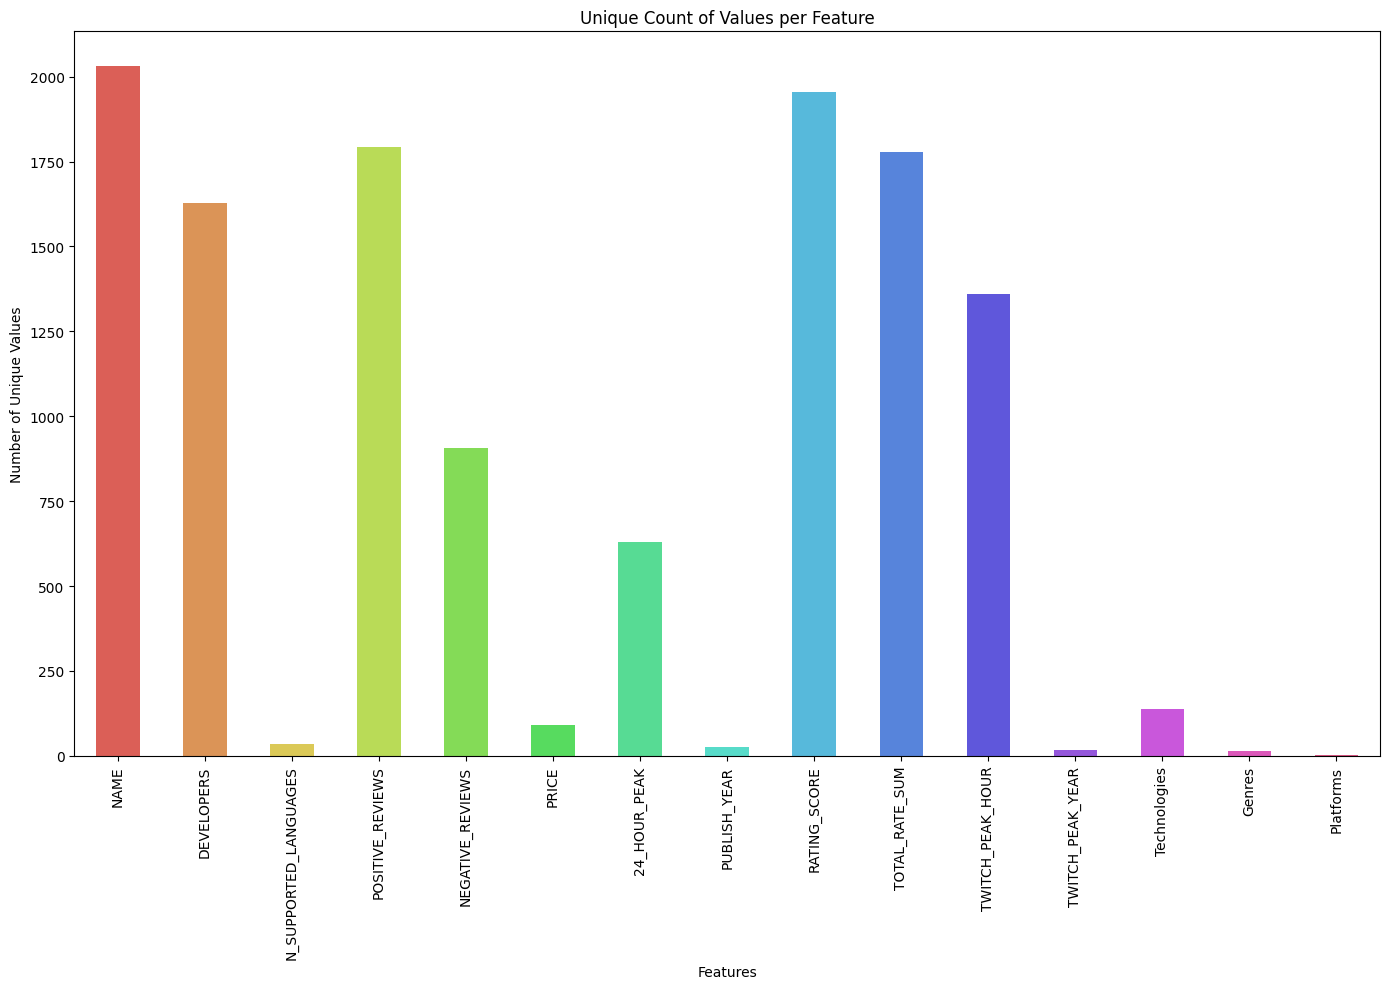

In [530]:
plt.figure(figsize=(14, 10))
counts.plot(kind='bar', color=colors)
plt.title('Unique Count of Values per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Outlier Detection and Handling

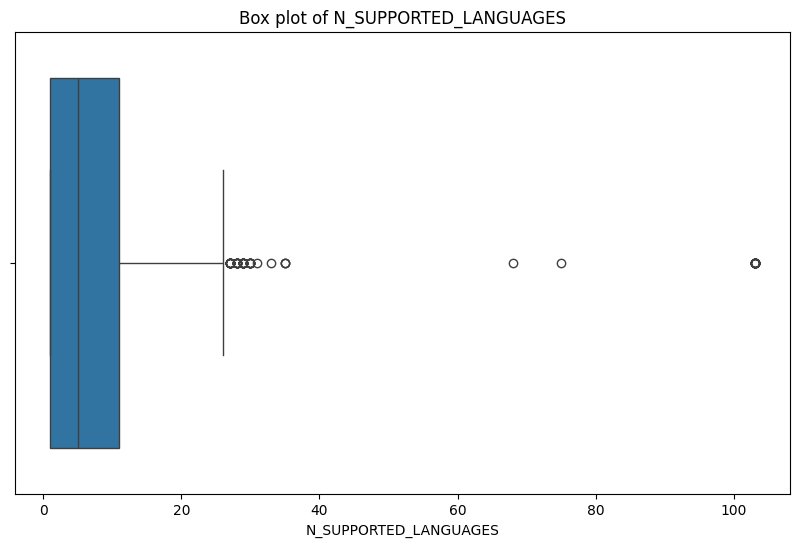

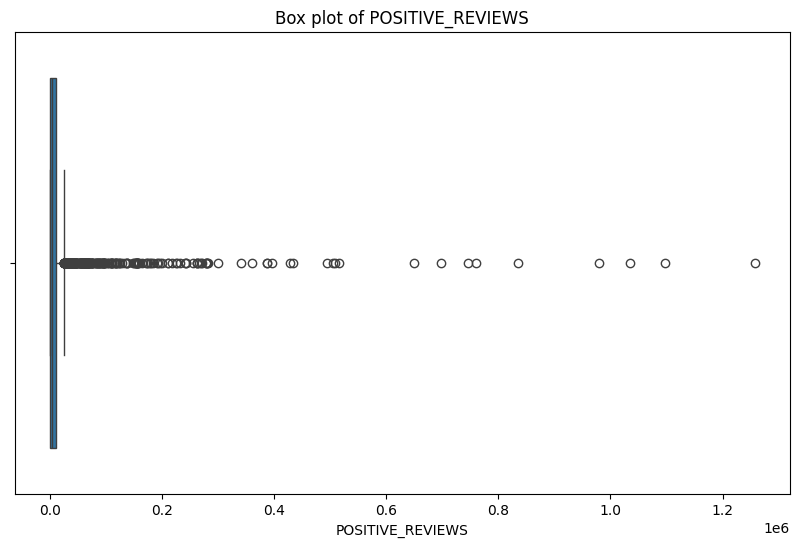

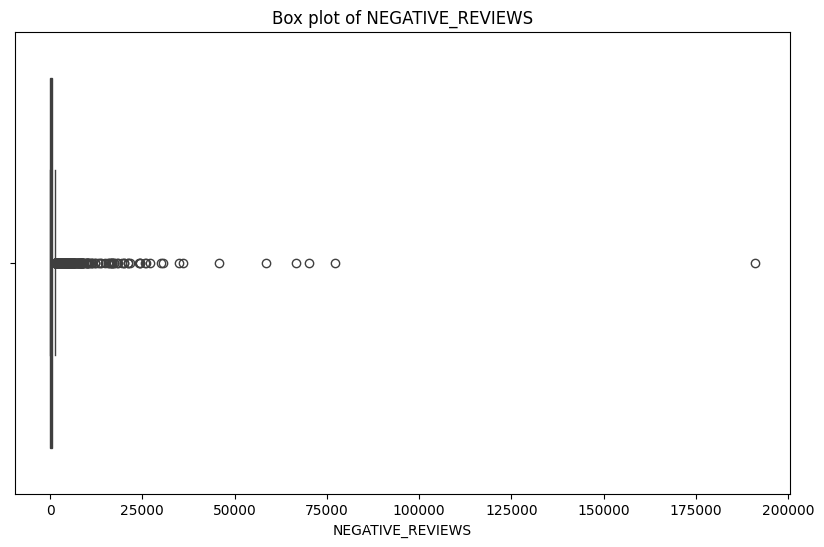

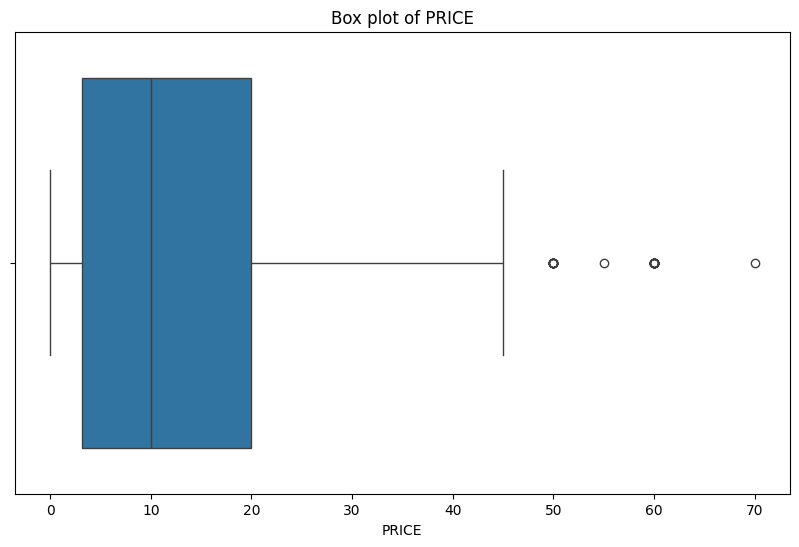

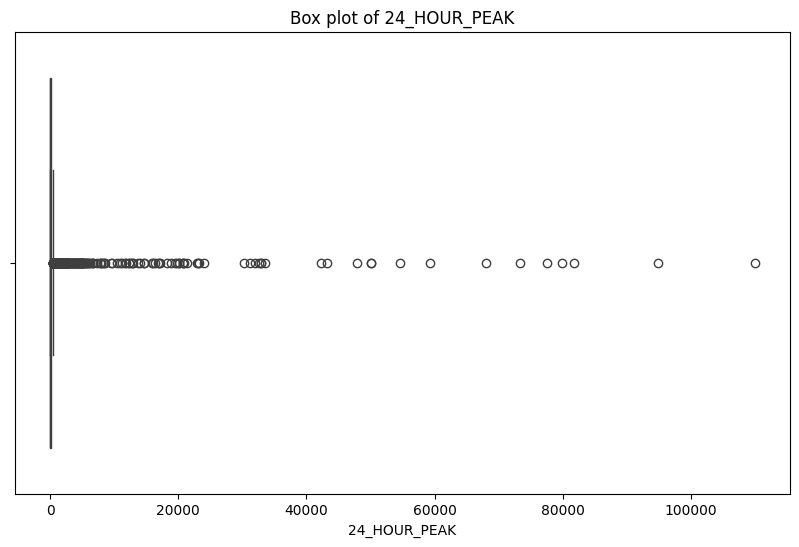

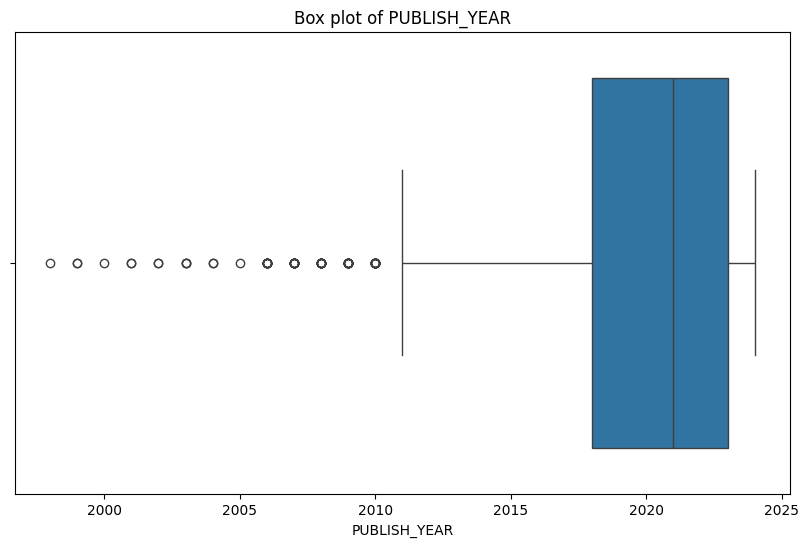

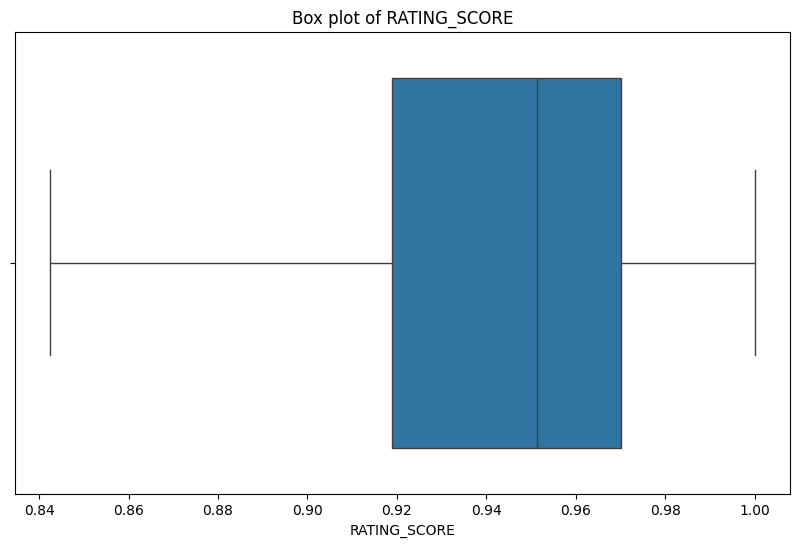

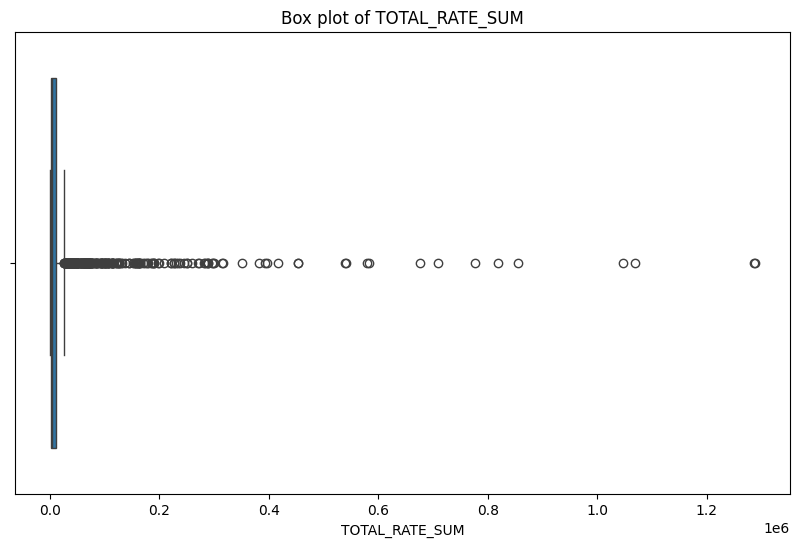

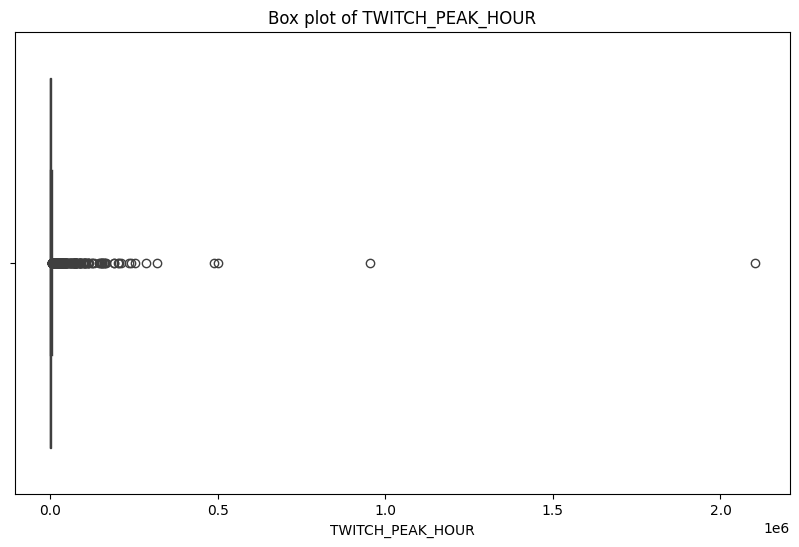

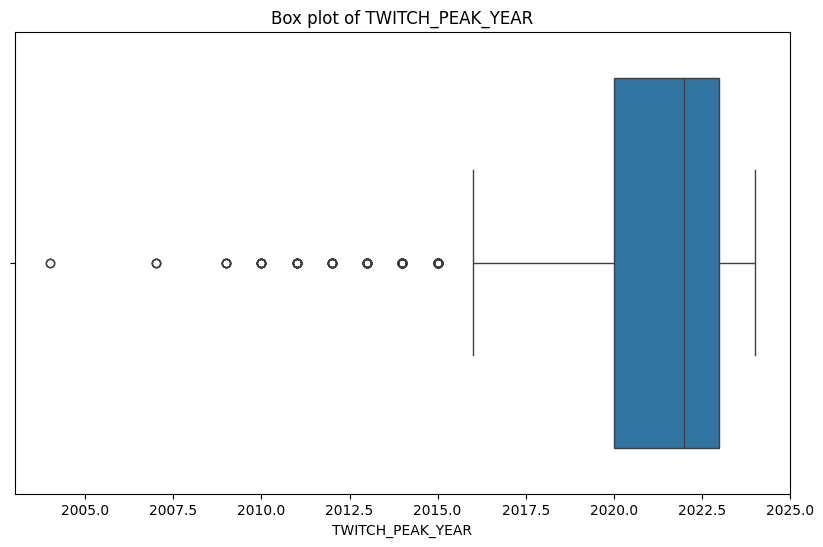

In [531]:
methods = {}

for column in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

    mean = df[column].mean()
    median = df[column].median()
    std = df[column].std()
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    
    if len(outliers) / len(df) < 0.05:
        if abs(mean - median) / std > 0.5:
            methods[column] = 'transform'
        else:
            methods[column] = 'remove'
    else:
        methods[column] = 'cap'

In [532]:
methods

{'N_SUPPORTED_LANGUAGES': 'remove',
 'POSITIVE_REVIEWS': 'cap',
 'NEGATIVE_REVIEWS': 'cap',
 'PRICE': 'remove',
 '24_HOUR_PEAK': 'cap',
 'PUBLISH_YEAR': 'remove',
 'RATING_SCORE': 'remove',
 'TOTAL_RATE_SUM': 'cap',
 'TWITCH_PEAK_HOUR': 'cap',
 'TWITCH_PEAK_YEAR': 'cap'}

**Outlier Handling Suggestions:**
- Transform: Suggested if there is a significant skew in the data (mean and median are far apart relative to the standard deviation).
- Remove: Suggested if the number of outliers is low and the data distribution is not heavily skewed.
- Cap: Suggested if the number of outliers is high, indicating that simply removing them might lead to loss of significant data.

In [533]:
# def handle_outliers(df, methods, exclude_columns=[]):

#     df_cleaned = df.copy()  
    
#     for column, method in methods.items():
#         if column in exclude_columns:
#             continue
        
#         Q1 = df_cleaned[column].quantile(0.25)
#         Q3 = df_cleaned[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         if method == 'remove':
#             df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
#         elif method == 'cap':
#             df_cleaned[column] = df_cleaned[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
#         elif method == 'transform':
#             df_cleaned[column] = np.log1p(df_cleaned[column])  
#         else:
#             raise ValueError("Method must be either 'remove', 'cap', or 'transform'")
    
#     return df_cleaned

In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 166 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(160)
memory usage: 2.6 MB


# Feature Engineering and Selection (Analysis) 

In [535]:
target_column = '24_HOUR_PEAK'

## Correlation Heatmap

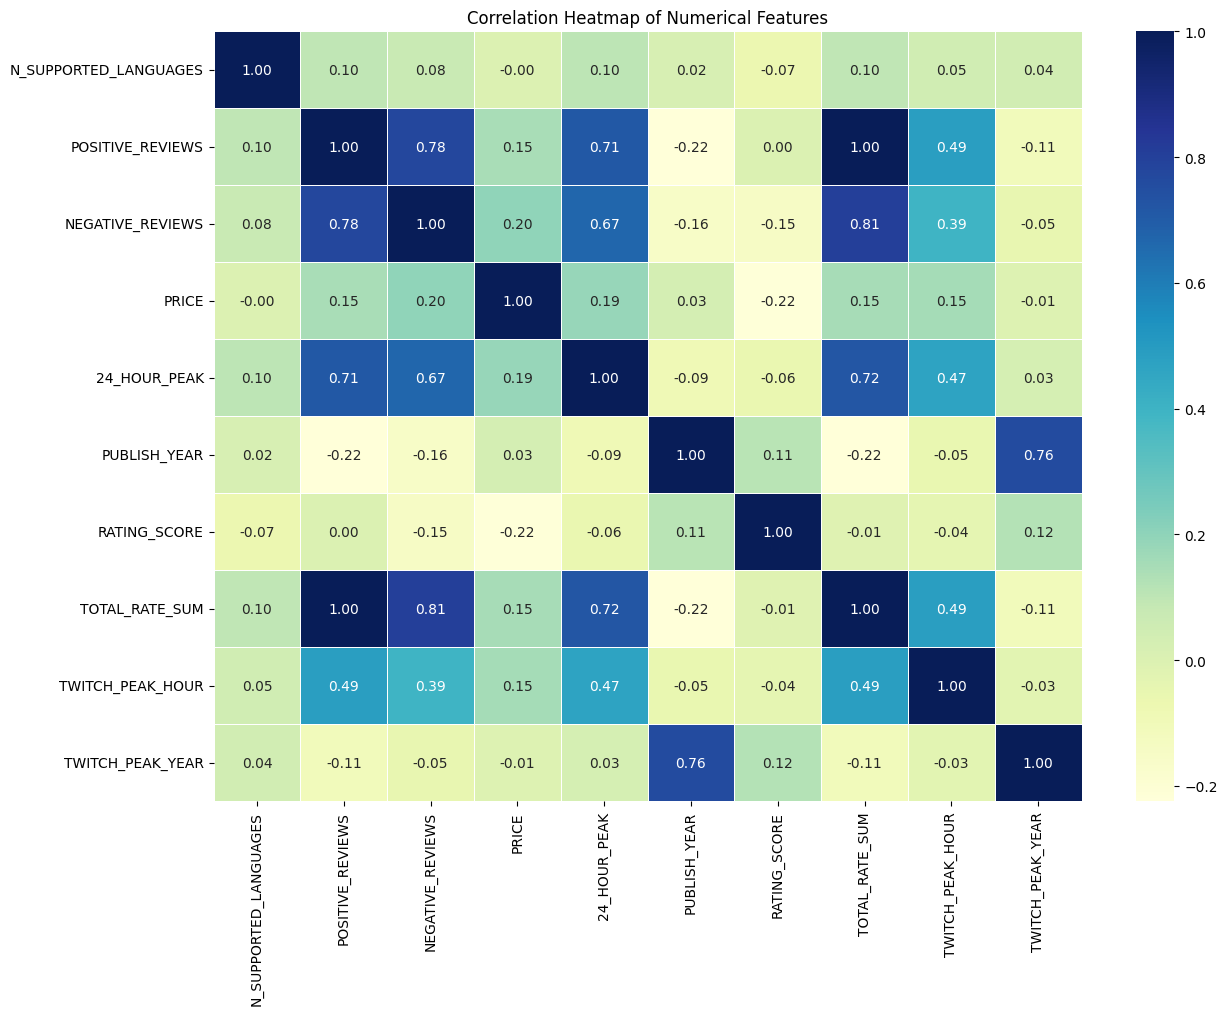

In [536]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [537]:
correlations_with_target = df[numerical_features + [target_column]].corr()[target_column].drop(target_column)

print("Correlation of numerical features with the target variable '24_HOUR_PEAK':")
print(correlations_with_target)


Correlation of numerical features with the target variable '24_HOUR_PEAK':
                       24_HOUR_PEAK  24_HOUR_PEAK
N_SUPPORTED_LANGUAGES      0.102634      0.102634
POSITIVE_REVIEWS           0.713983      0.713983
NEGATIVE_REVIEWS           0.667456      0.667456
PRICE                      0.185387      0.185387
PUBLISH_YEAR              -0.087232     -0.087232
RATING_SCORE              -0.059560     -0.059560
TOTAL_RATE_SUM             0.721471      0.721471
TWITCH_PEAK_HOUR           0.465874      0.465874
TWITCH_PEAK_YEAR           0.027272      0.027272


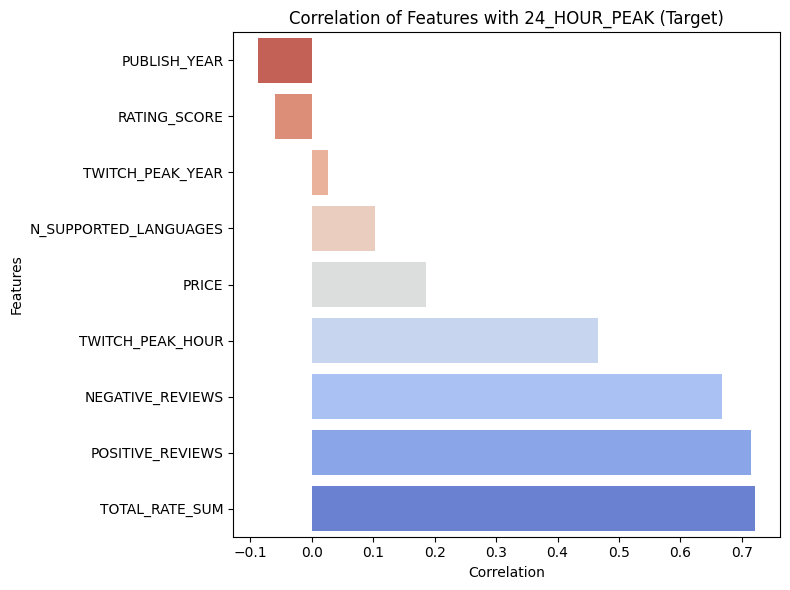

In [538]:
target_correlation = correlation_matrix['24_HOUR_PEAK'].drop('24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## Histograms

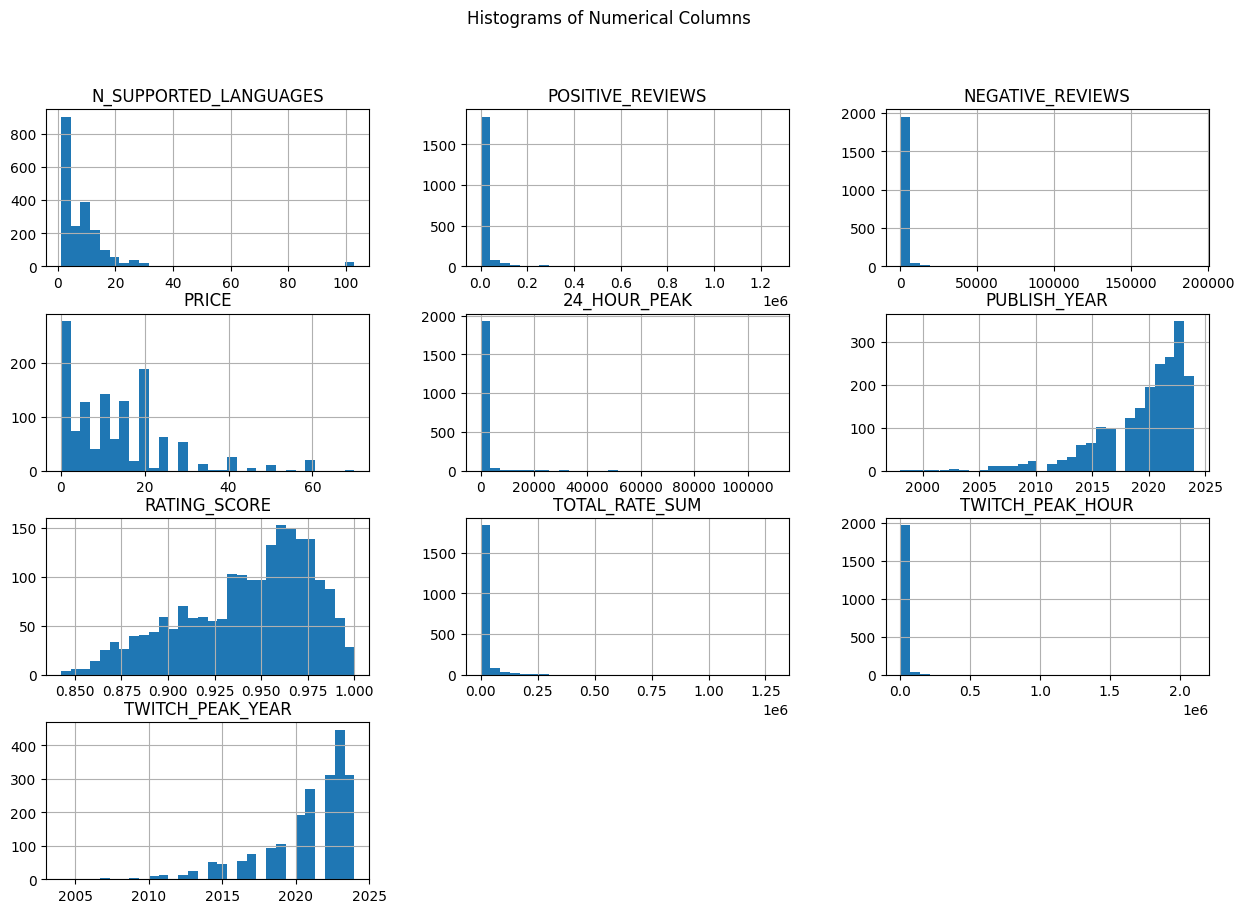

In [539]:
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns")
plt.show()

##  Plot pair plot

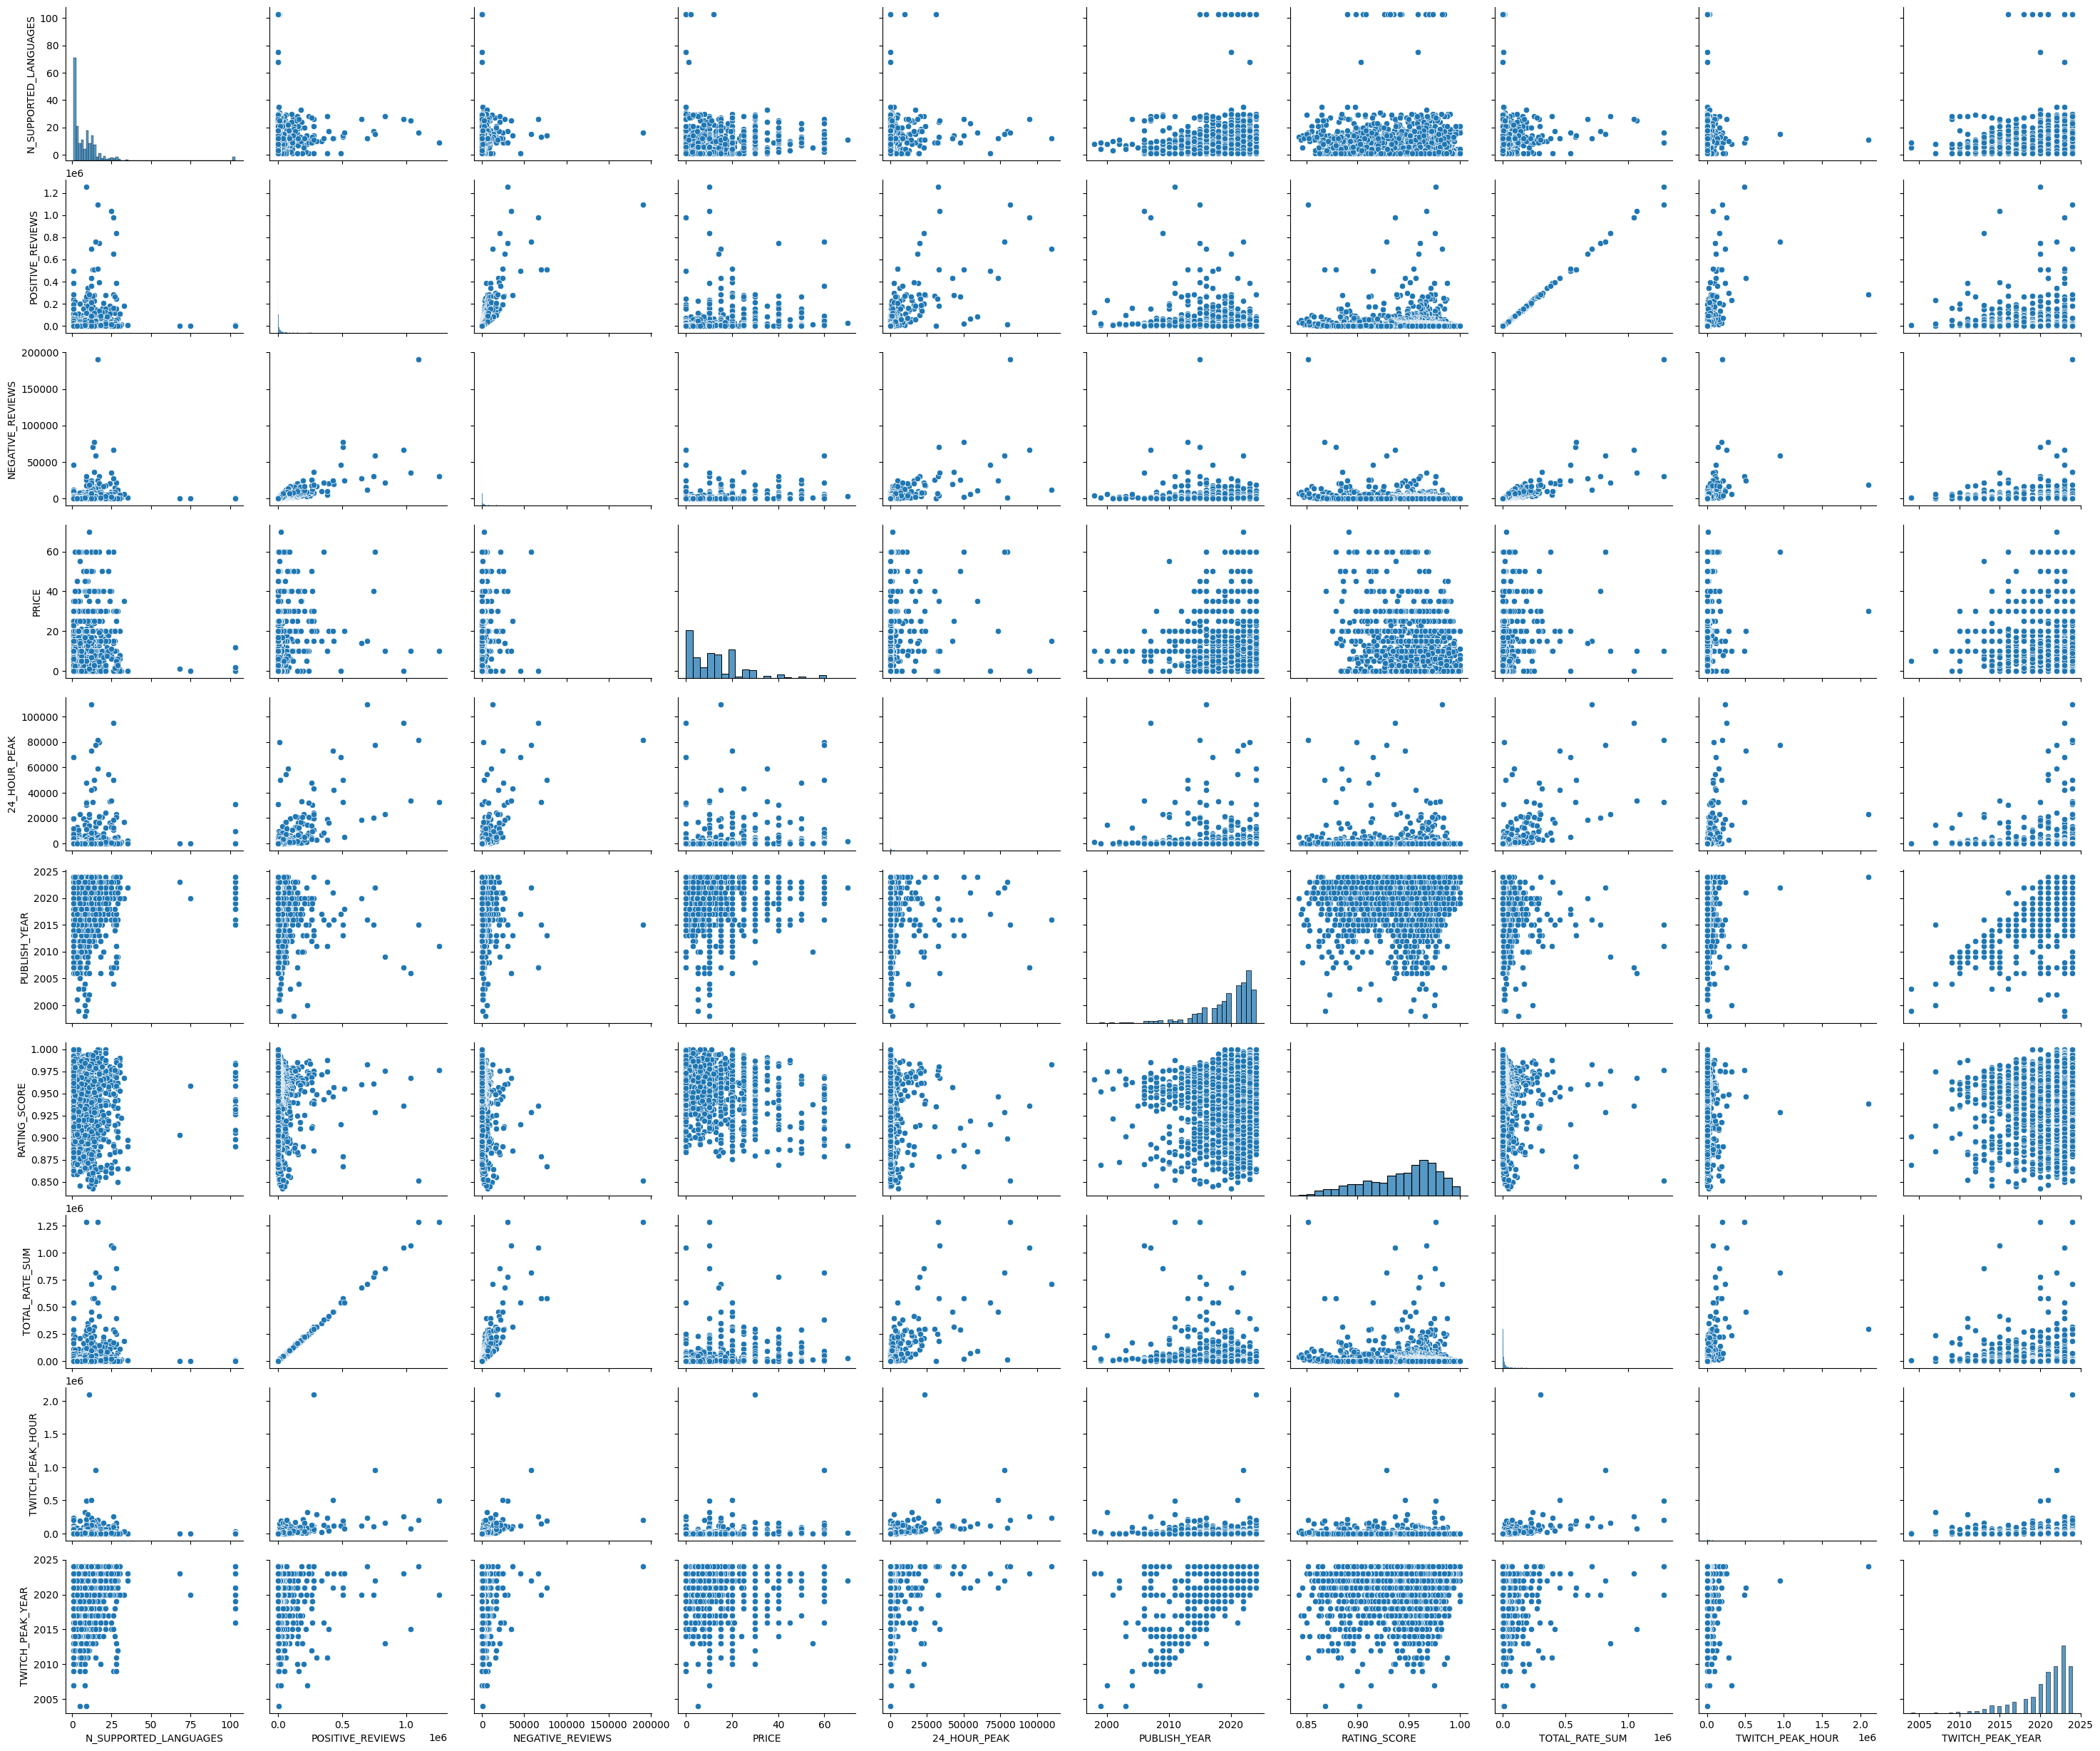

In [540]:
sns.pairplot(df[numerical_features], height=2.5, aspect=1.2)
plt.show()

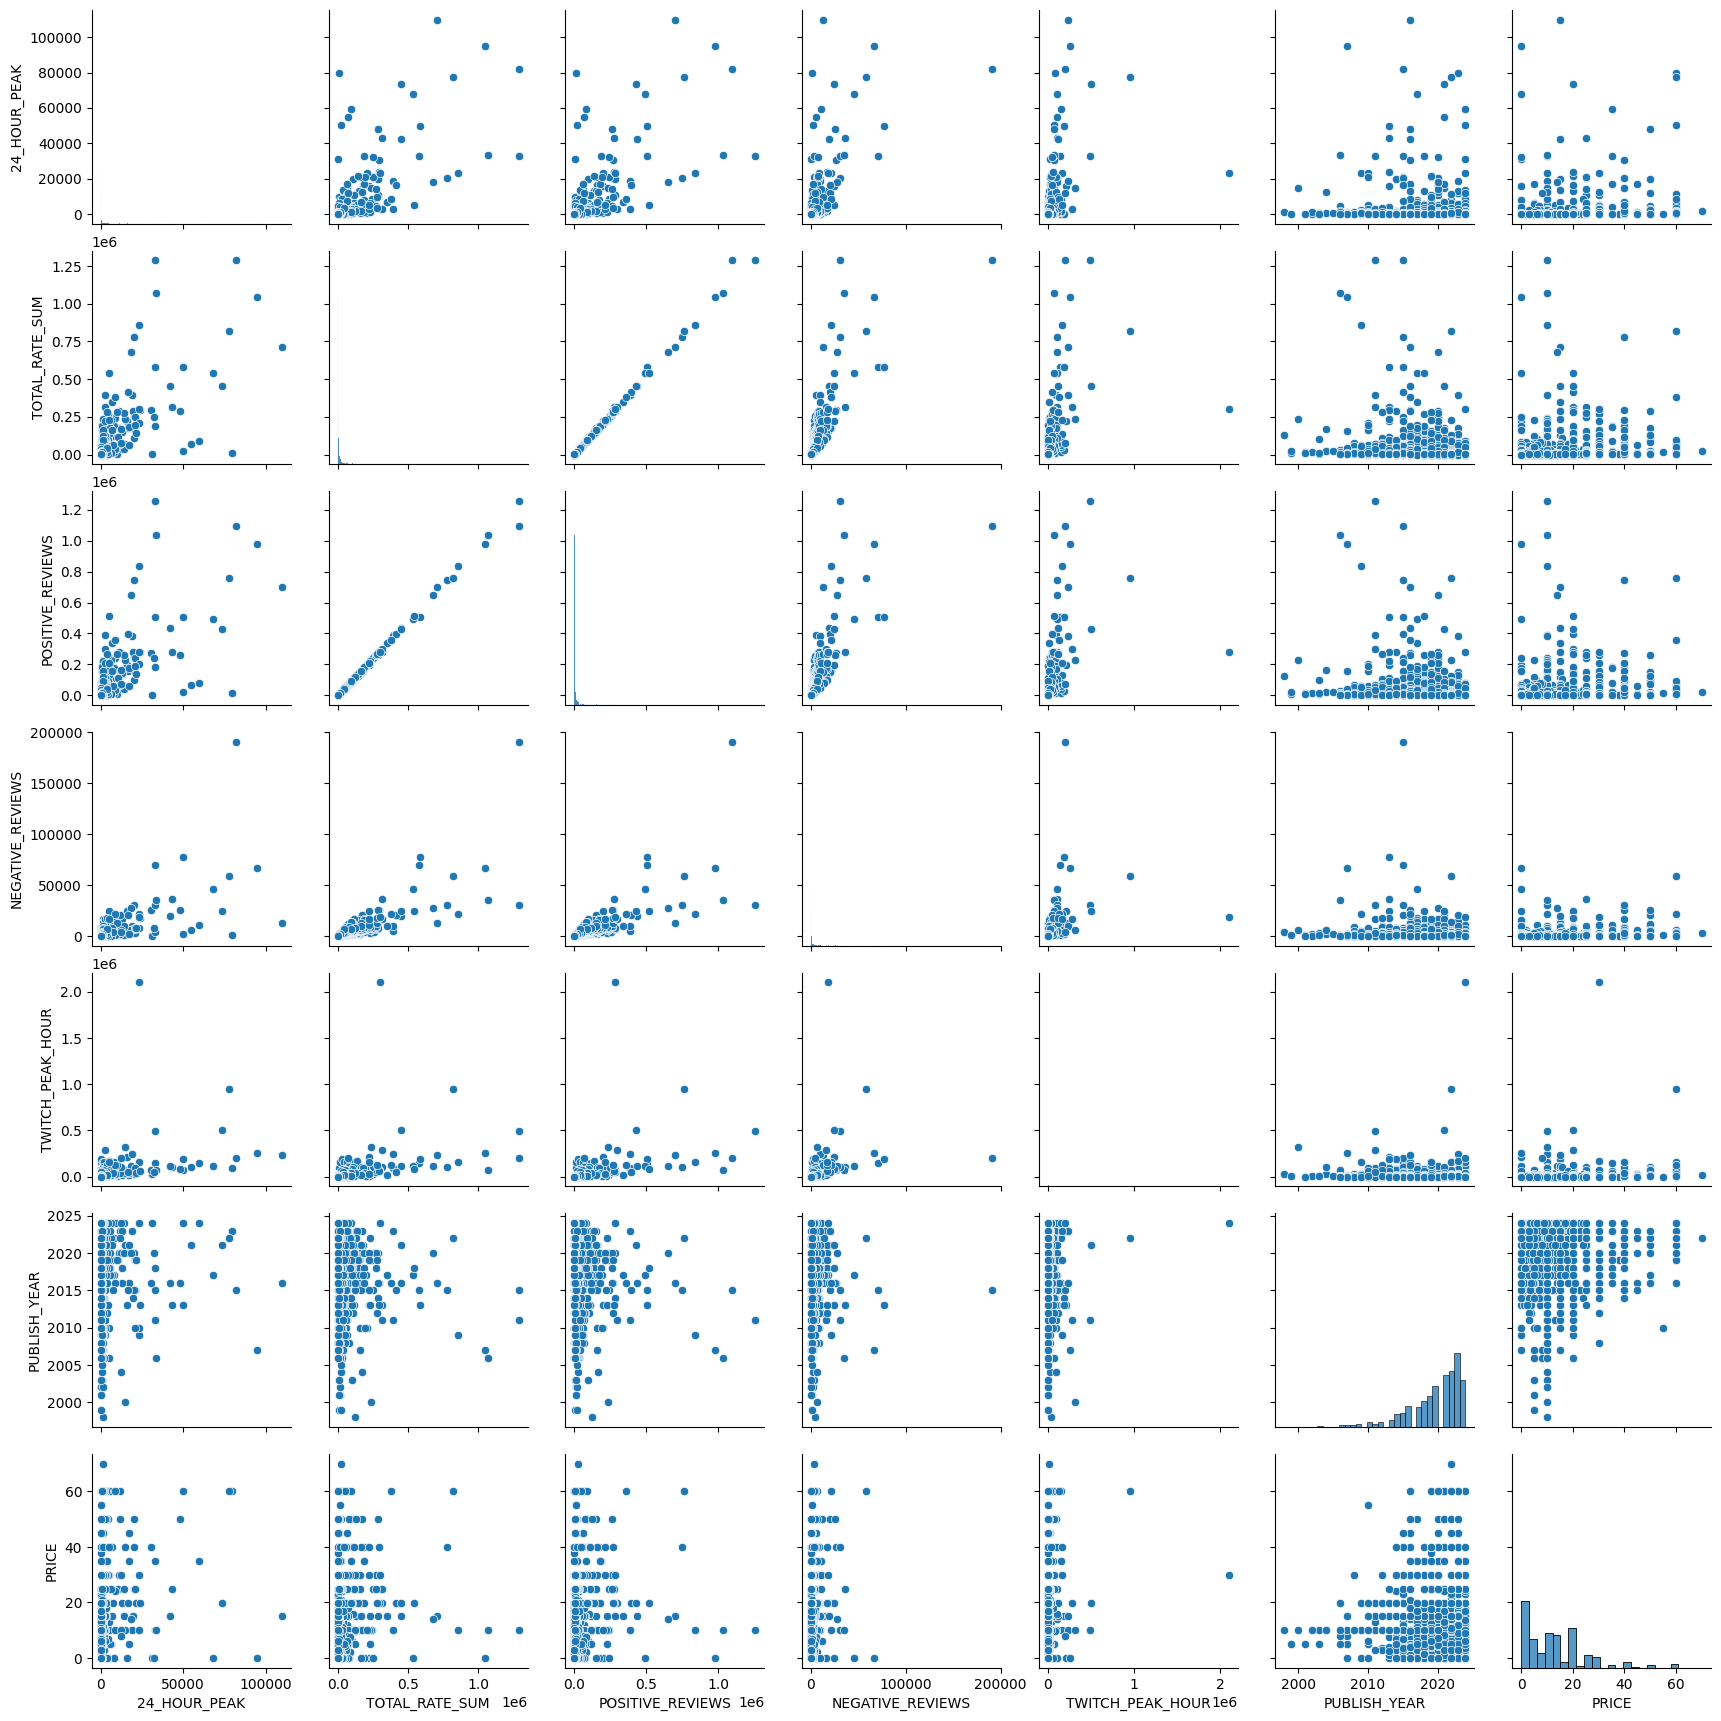

In [541]:
selected_features = ['24_HOUR_PEAK', 'TOTAL_RATE_SUM', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TWITCH_PEAK_HOUR', 'PUBLISH_YEAR', 'PRICE']

sns.pairplot(df[selected_features])
plt.show()

## Summary statistics for the `24_HOUR_PEAK` column

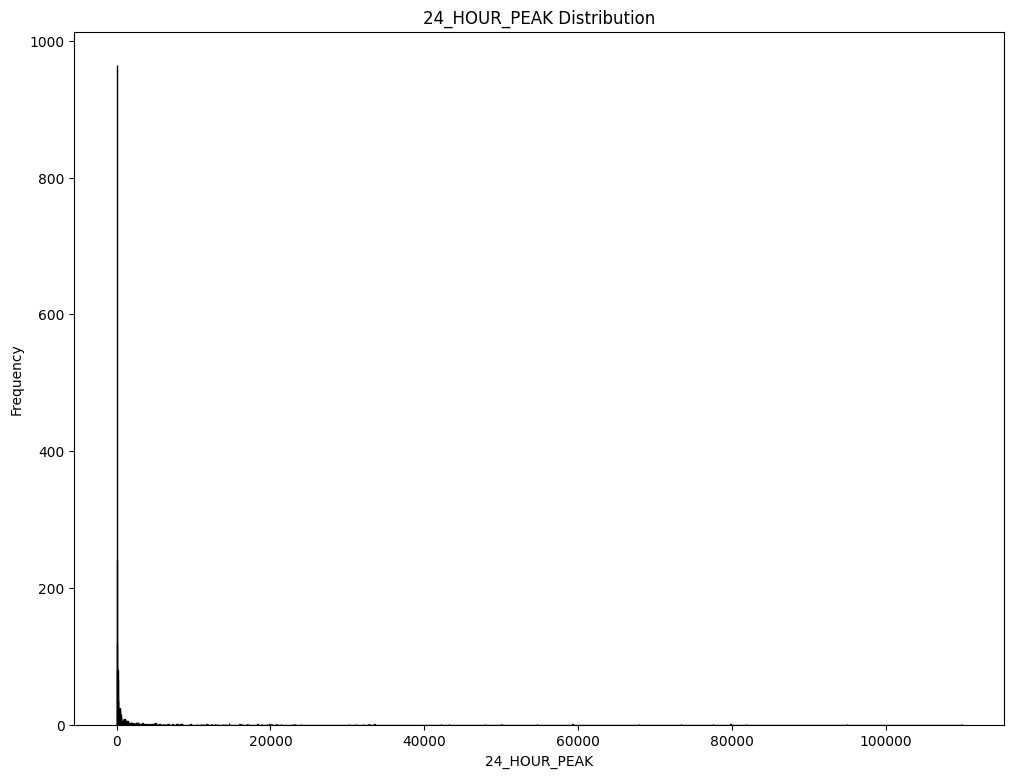

In [542]:
plt.hist(df['24_HOUR_PEAK'], bins='auto', color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.xlabel('24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.title('24_HOUR_PEAK Distribution')
plt.show()

In [543]:
df['24_HOUR_PEAK'].describe()

count      2032.000000
mean       1185.736713
std        6441.760299
min           0.000000
25%          10.000000
50%          36.500000
75%         210.000000
max      109950.000000
Name: 24_HOUR_PEAK, dtype: float64

## Log Transformation (`24_HOUR_PEAK`)

In [544]:
if 'log_24_HOUR_PEAK' not in df.columns:
    df['log_24_HOUR_PEAK'] = np.log1p(df['24_HOUR_PEAK'])
    numerical_features.append('log_24_HOUR_PEAK')

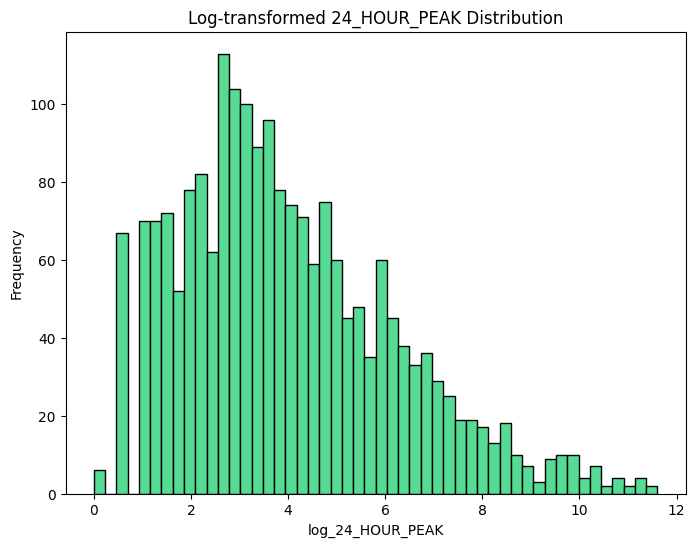

In [545]:
plt.figure(figsize=(8, 6))
plt.hist(df['log_24_HOUR_PEAK'], bins=50, color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.title('Log-transformed 24_HOUR_PEAK Distribution')
plt.xlabel('log_24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.show()

In [546]:
df['log_24_HOUR_PEAK'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2032 entries, 0 to 2031
Series name: log_24_HOUR_PEAK
Non-Null Count  Dtype  
--------------  -----  
2032 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [547]:
df['log_24_HOUR_PEAK'].isnull().sum()

0

## Summary statistics for the `PRICE` column

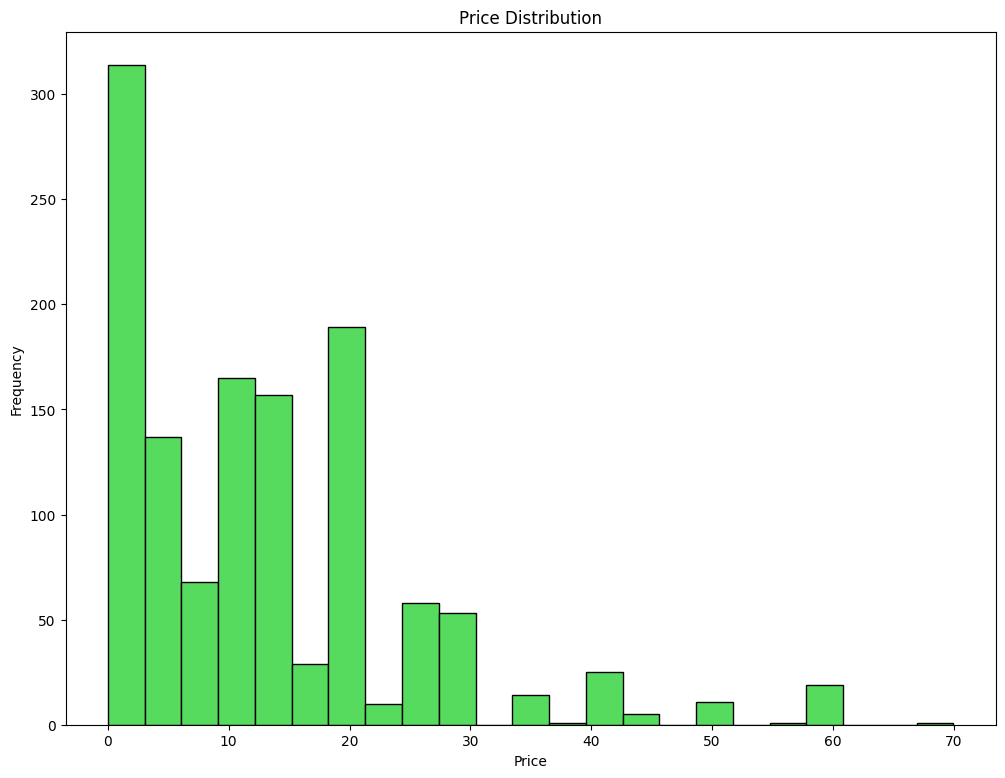

In [548]:
plt.hist(df['PRICE'], bins='auto', color=feature_color_map['PRICE'], edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

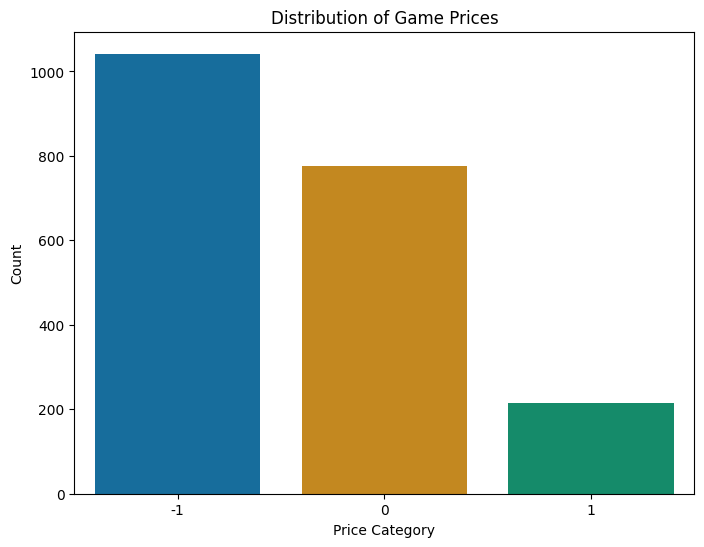

In [549]:
def categorize_price(price):
    if pd.isna(price):
        return 0
    elif price == 0:
        return 1
    else:
        return -1

df = df.assign(PRICE_CATEGORY=df['PRICE'].apply(categorize_price))

price_category_counts = df['PRICE_CATEGORY'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=price_category_counts.index, y=price_category_counts.values, palette='colorblind')

plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Game Prices')
plt.show()


In [550]:
df['PRICE'].describe()

count    1257.000000
mean       13.113294
std        12.243899
min         0.000000
25%         3.190000
50%         9.990000
75%        19.990000
max        69.990000
Name: PRICE, dtype: float64

In [551]:
df['PRICE'].isnull().sum()

775

##  Summary statistics for the `PUBLISH_YEAR` column

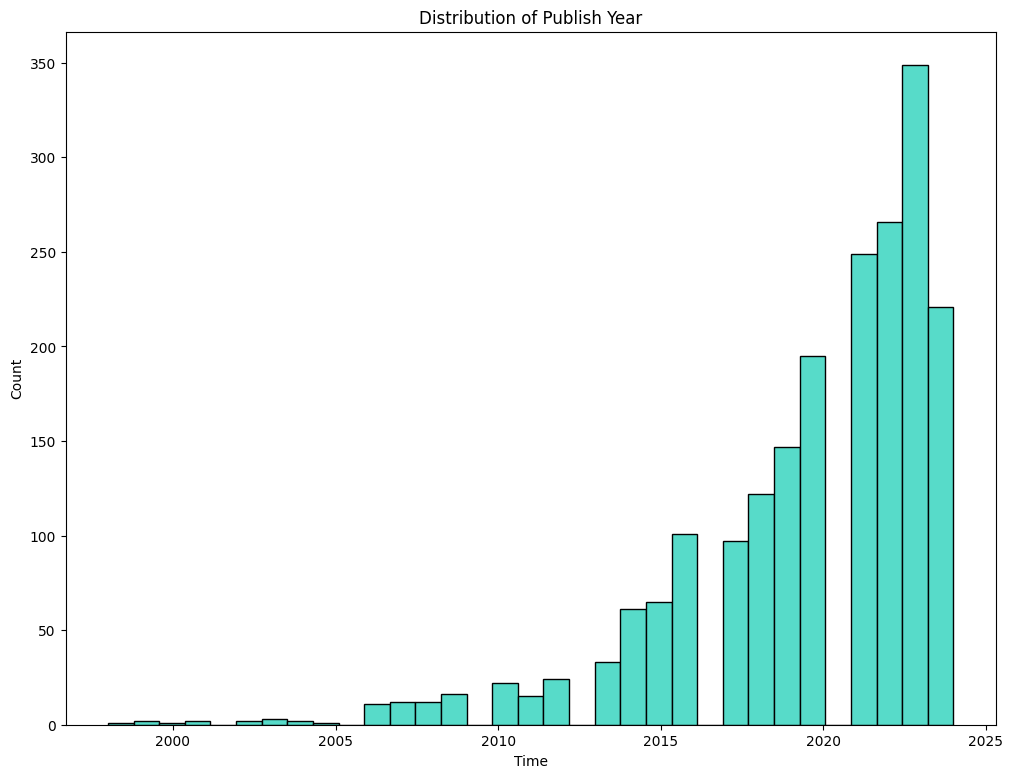

In [552]:
plt.hist(df['PUBLISH_YEAR'], bins='auto', color=feature_color_map['PUBLISH_YEAR'], edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Publish Year')
plt.show()

In [553]:
df['PUBLISH_YEAR'].describe()

count    2032.000000
mean     2019.641240
std         4.081244
min      1998.000000
25%      2018.000000
50%      2021.000000
75%      2023.000000
max      2024.000000
Name: PUBLISH_YEAR, dtype: float64

## Plot the average `24_HOUR_PEAK` for each year (`PUBLISH_YEAR`)

In [554]:
print(sorted(df["PUBLISH_YEAR"].unique()))

[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


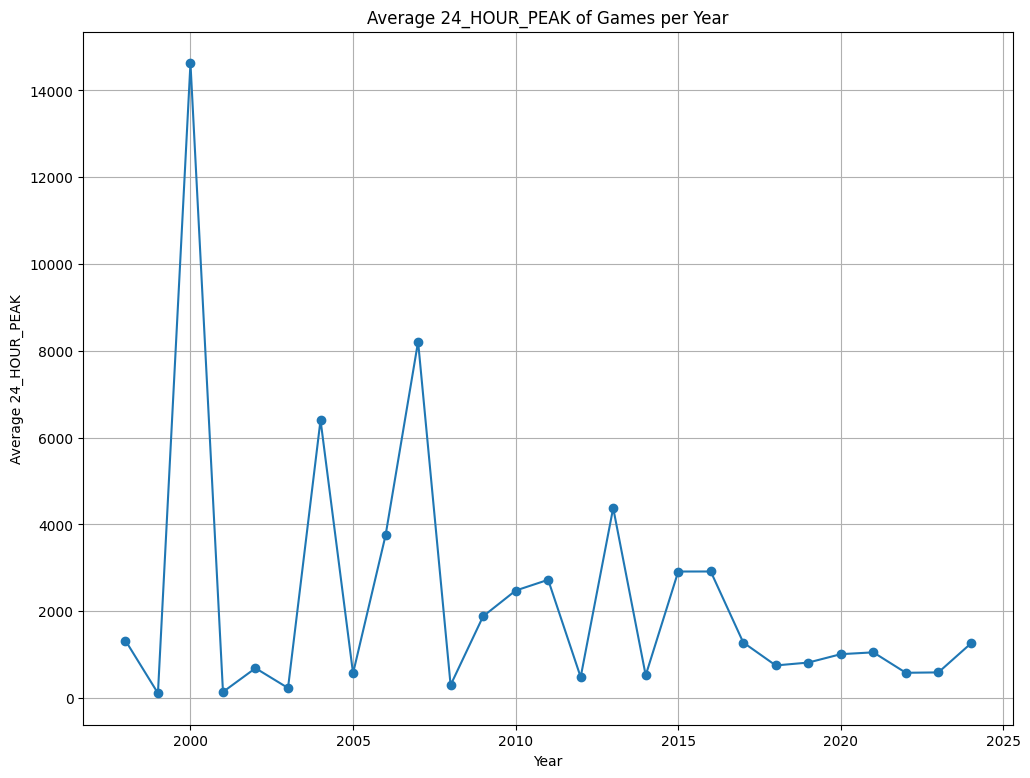

In [555]:
average_peak24_per_year = df.groupby('PUBLISH_YEAR')['24_HOUR_PEAK'].mean()

plt.plot(average_peak24_per_year.index, average_peak24_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average 24_HOUR_PEAK')
plt.title('Average 24_HOUR_PEAK of Games per Year')
plt.grid(True)
plt.show()

## `Platform` Analysis

OS: Linux 2034.064833005894
OS: Windows 1185.7367125984251
OS: macOS 1597.2536520584329


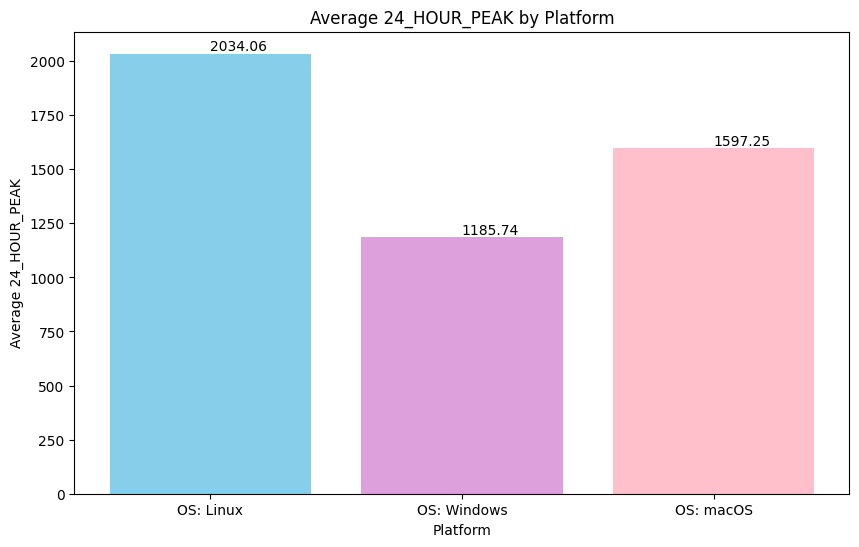

In [556]:
averages = []
for platform in platforms:
    avg = df.loc[df[platform] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(platform, avg)
colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.bar(platforms, averages, color=colors)

for bar, avg in zip(bars, averages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(avg, 2), va='bottom')  # va: vertical alignment

plt.title('Average 24_HOUR_PEAK by Platform')
plt.xlabel('Platform')
plt.ylabel('Average 24_HOUR_PEAK')
plt.show()

del averages


In [557]:
df['PLATFORM_COUNT'] = df[platforms].sum(axis=1)
numerical_features.append('PLATFORM_COUNT')

platform_groups = df.groupby('PLATFORM_COUNT').agg({
    '24_HOUR_PEAK': 'mean'
})

platform_groups.reset_index(inplace=True)

platform_groups

,PLATFORM_COUNT,24_HOUR_PEAK
0,1,891.025556
1,2,1114.720745
2,3,2052.975169


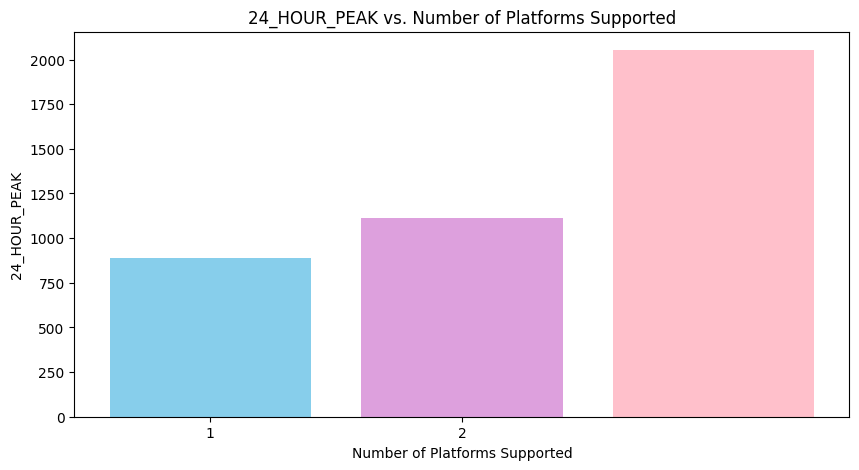

In [558]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(platform_groups['PLATFORM_COUNT'], platform_groups[metric], color=colors)
    plt.xlabel('Number of Platforms Supported')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Number of Platforms Supported')
    plt.xticks(range(1, 3))
    plt.show()

##  Relation between `24_HOUR_PEAK` and `STORE_GENRE`

GENRE: Action 1684.2761104441777
GENRE: Adventure 846.6421052631579
GENRE: Casual 497.15686274509807
GENRE: Early Access 1883.779761904762
GENRE: Free to Play 1593.5118110236222
GENRE: Indie 815.6311475409836
GENRE: Massively Multiplayer 5630.611111111111
GENRE: RPG 2044.4896073903003
GENRE: Racing 1816.388888888889
GENRE: Simulation 1857.577731092437
GENRE: Sports 3348.6666666666665
GENRE: Store Genres 110.0
GENRE: Strategy 1770.7415384615385


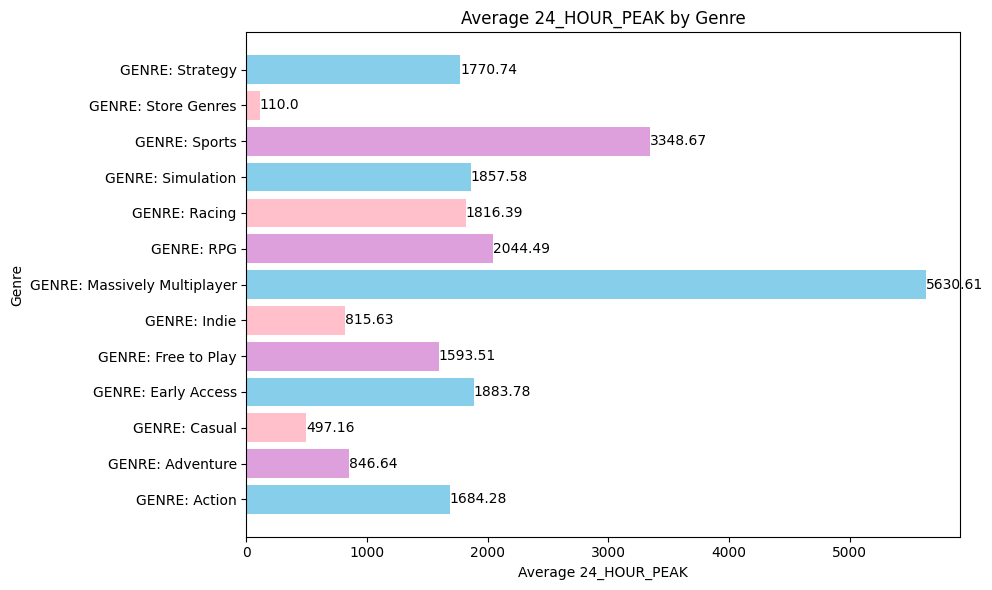

In [559]:

averages = []
for genre in genres:
    avg = df.loc[df[genre] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(genre, avg)

colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.barh(genres, averages, color=colors)

for bar, avg in zip(bars, averages):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2, round(avg, 2), va='center', ha='left')

plt.title('Average 24_HOUR_PEAK by Genre')
plt.ylabel('Genre')
plt.xlabel('Average 24_HOUR_PEAK')
plt.tight_layout()
plt.show()

In [560]:
df['GENRE_COUNT'] = df[genres].sum(axis=1)
numerical_features.append('GENRE_COUNT')

genres_groups = df.groupby('GENRE_COUNT').agg({
    '24_HOUR_PEAK': 'mean'
})

genres_groups.reset_index(inplace=True)

genres_groups

,GENRE_COUNT,24_HOUR_PEAK
0,1,1361.958944
1,2,1020.815466
2,3,1013.255118
3,4,867.419255
4,5,2796.383929
5,6,1846.976744
6,7,9656.600000
7,8,231.500000
8,9,19.333333


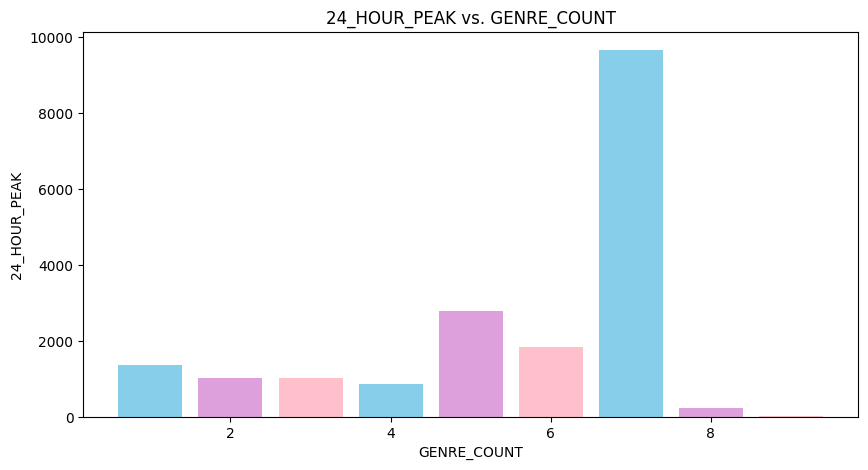

In [561]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(genres_groups['GENRE_COUNT'], genres_groups[metric], color=colors)
    plt.xlabel('GENRE_COUNT')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. GENRE_COUNT')
    plt.show()

## Analyze `REVIEWS` metrics

In [562]:
df.head(1)

,NAME,N_SUPPORTED_LANGUAGES,DEVELOPERS,POSITIVE_REVIEWS,NEGATIVE_REVIEWS,PRICE,24_HOUR_PEAK,PUBLISH_YEAR,RATING_SCORE,TOTAL_RATE_SUM,...,GENRE: Sports,GENRE: Store Genres,GENRE: Strategy,OS: Linux,OS: Windows,OS: macOS,log_24_HOUR_PEAK,PRICE_CATEGORY,PLATFORM_COUNT,GENRE_COUNT
0,470,7,205,39271,5015,NaN,1064.0,2016,0.886759,44286,...,0,0,0,0,1,0,6.97073,0,1,3


In [563]:
if 'NEGATIVE_REVIEWS_percentage' not in df.columns:
    df['NEGATIVE_REVIEWS_percentage'] = df['NEGATIVE_REVIEWS']/df['TOTAL_RATE_SUM']
    numerical_features.append('NEGATIVE_REVIEWS_percentage')

reviews = ['RATING_SCORE', 'NEGATIVE_REVIEWS_percentage', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TOTAL_RATE_SUM']


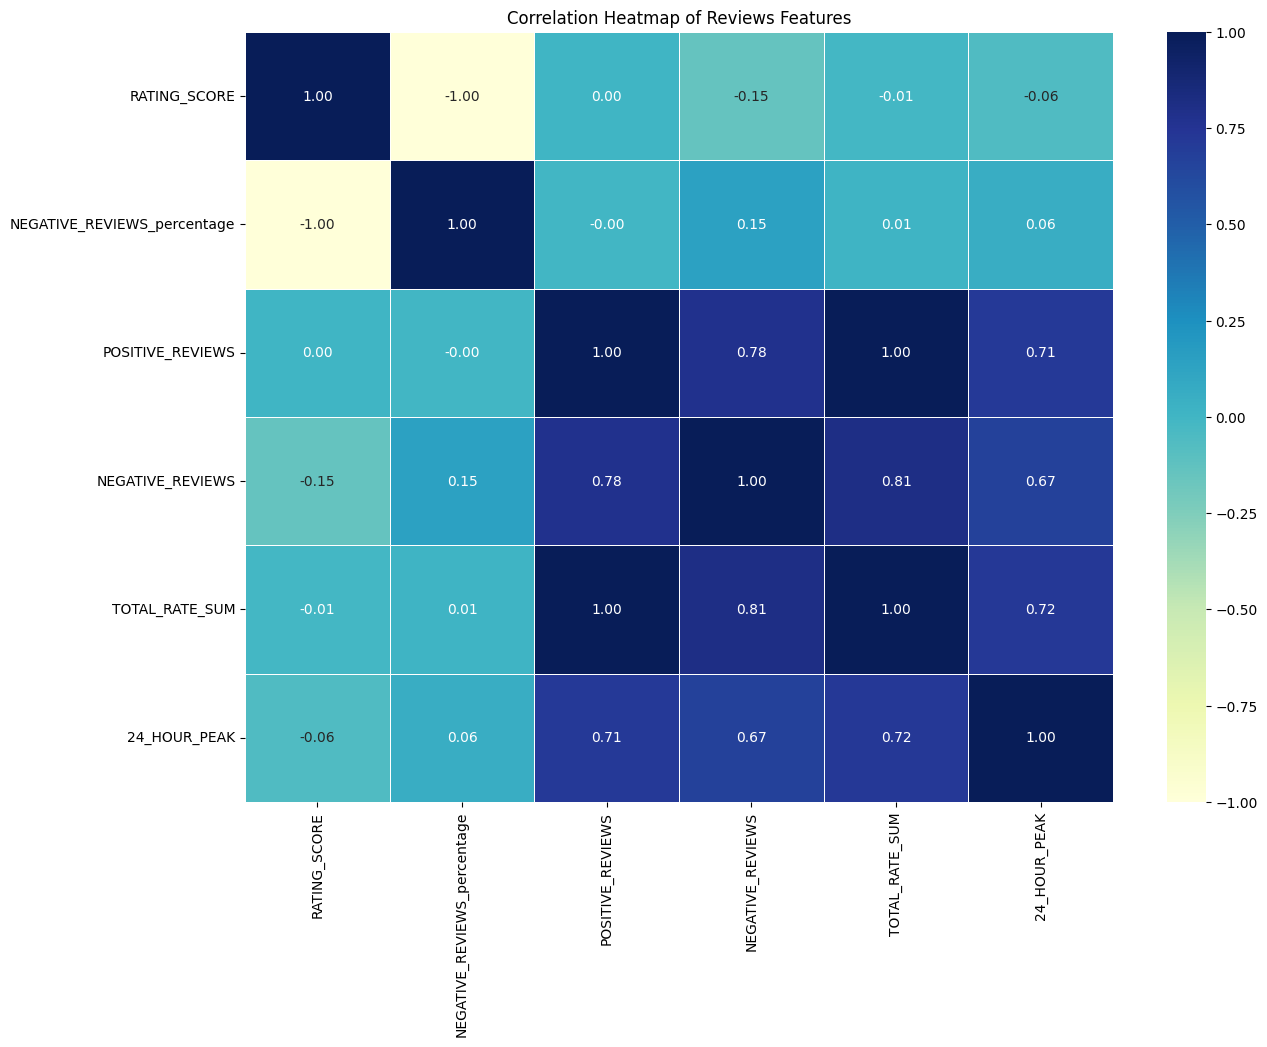

In [564]:
targets = reviews 
targets.append('24_HOUR_PEAK')



correlation_matrix = df[targets].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Reviews Features')
plt.show()

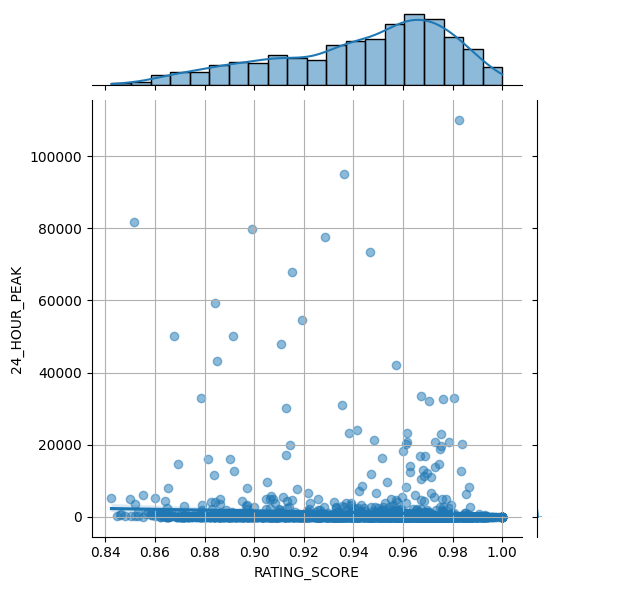

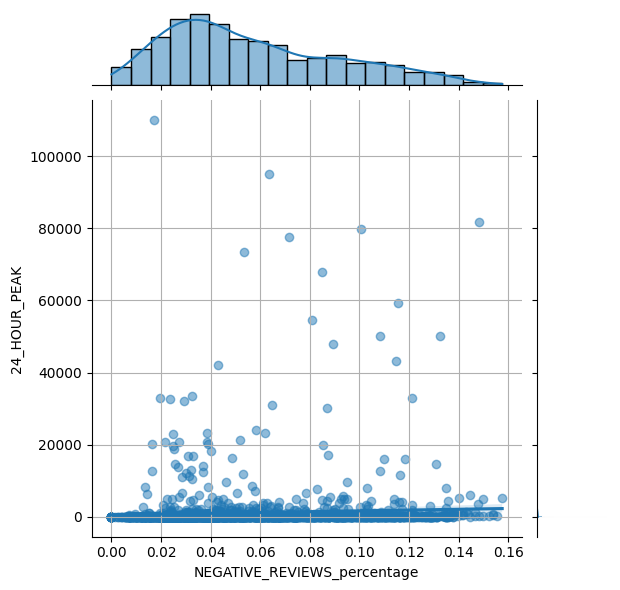

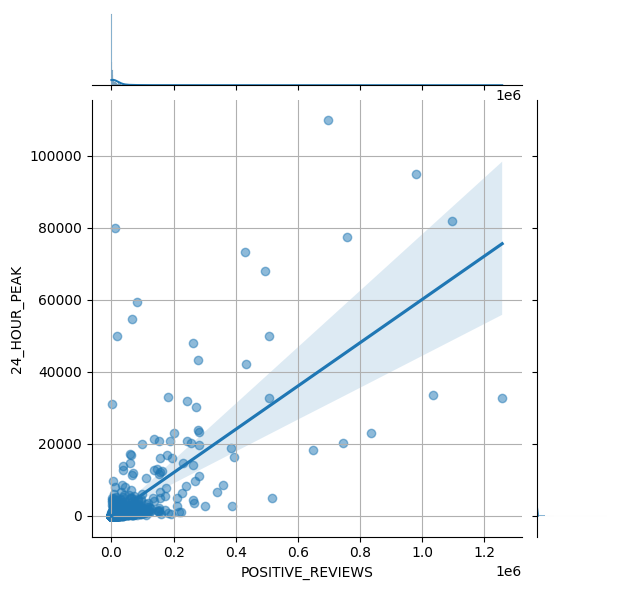

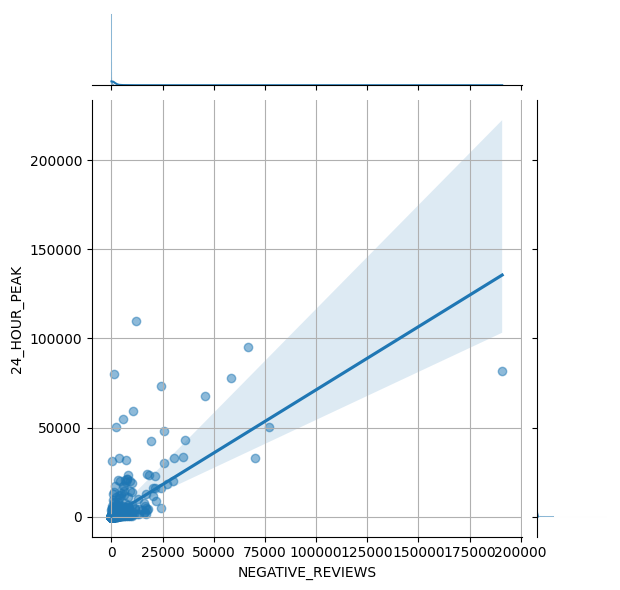

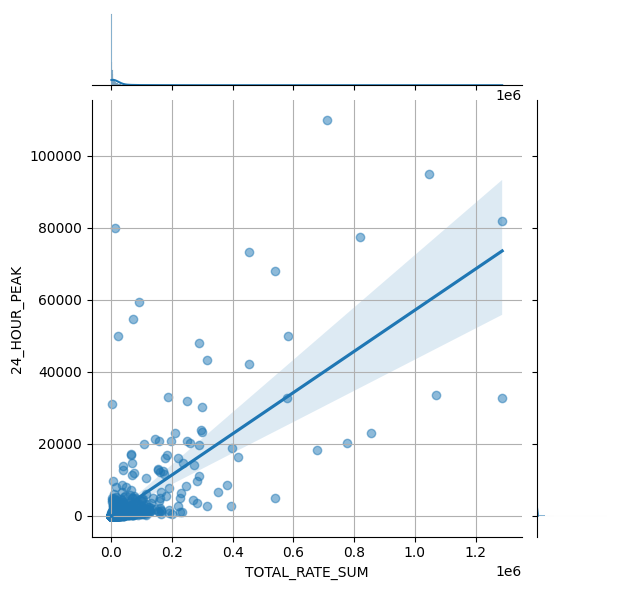

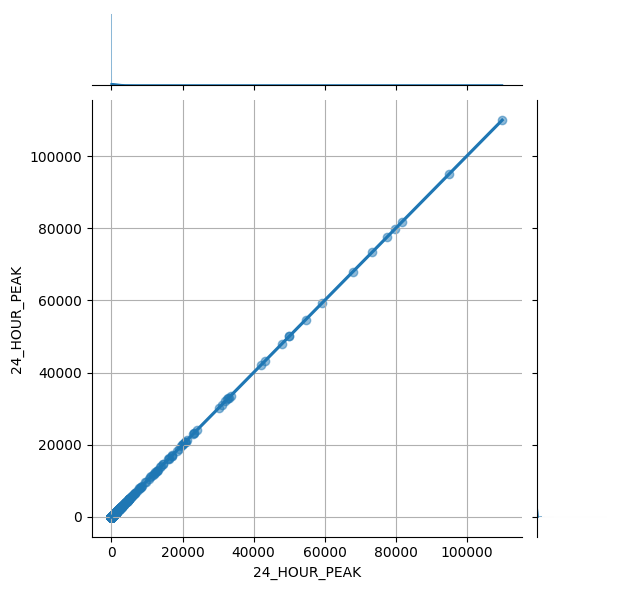

In [565]:
for metric in reviews:
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='reg', scatter_kws={'alpha':0.5})
    plt.xlabel(f'{metric}')
    plt.ylabel('24_HOUR_PEAK')
    plt.grid(True)
    plt.show()
    

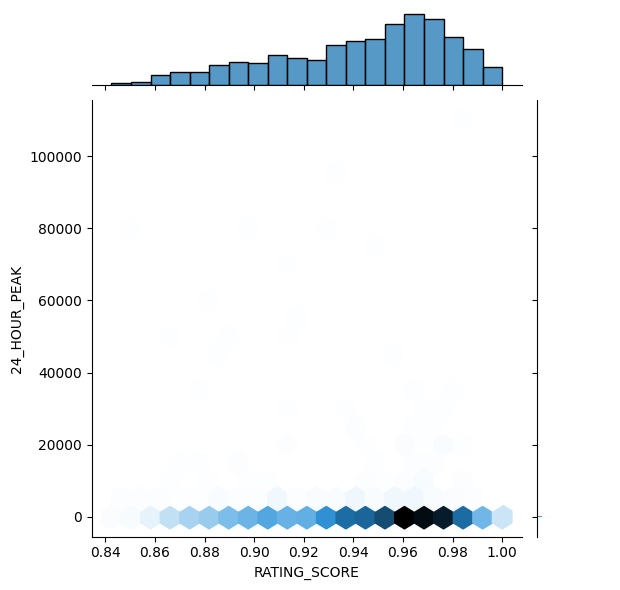

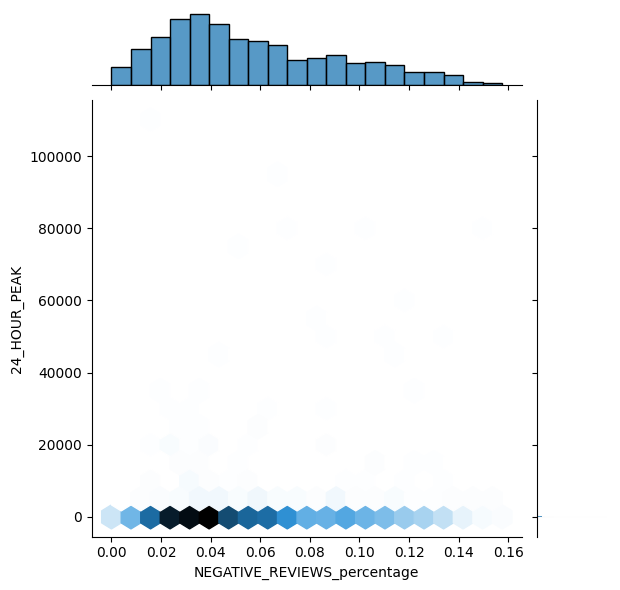

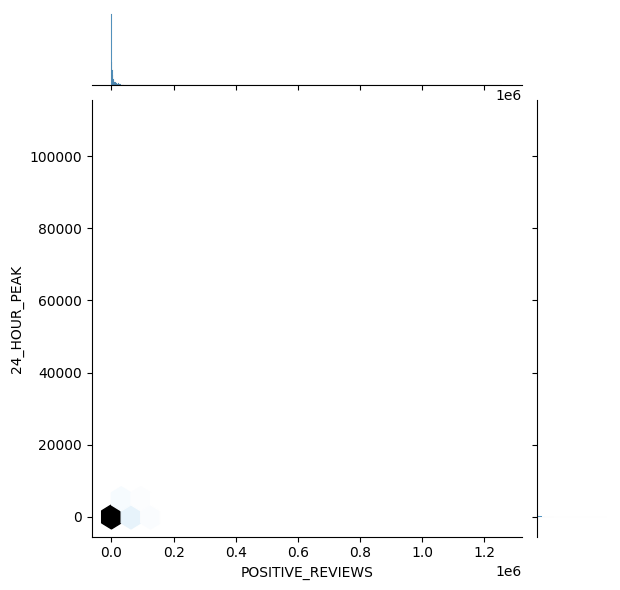

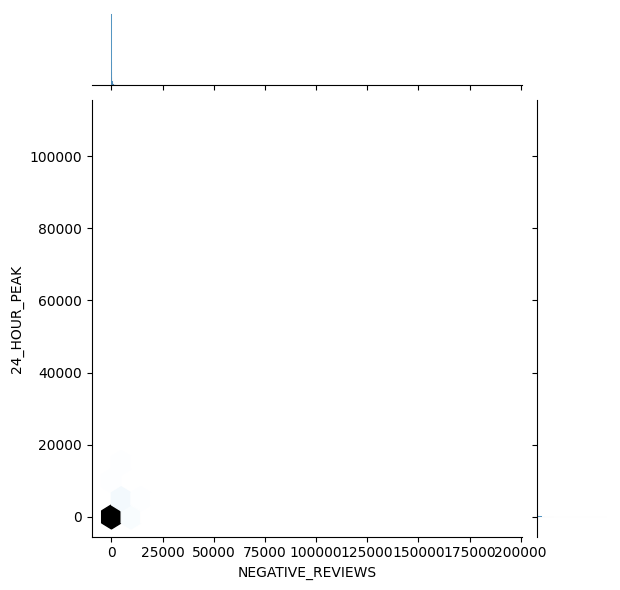

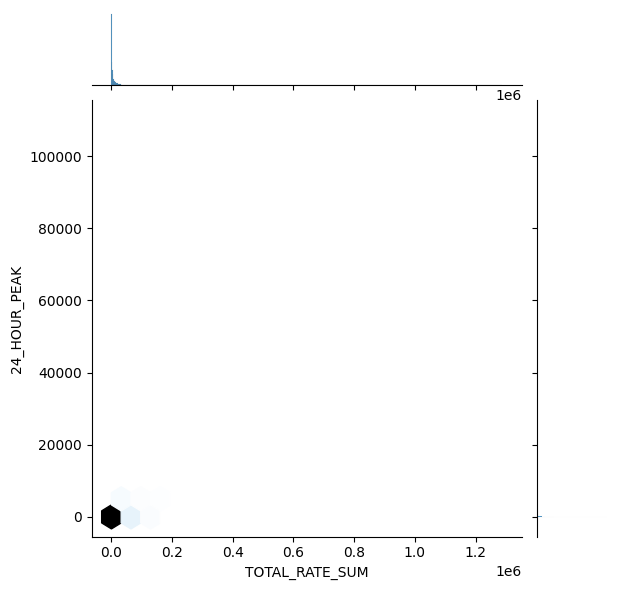

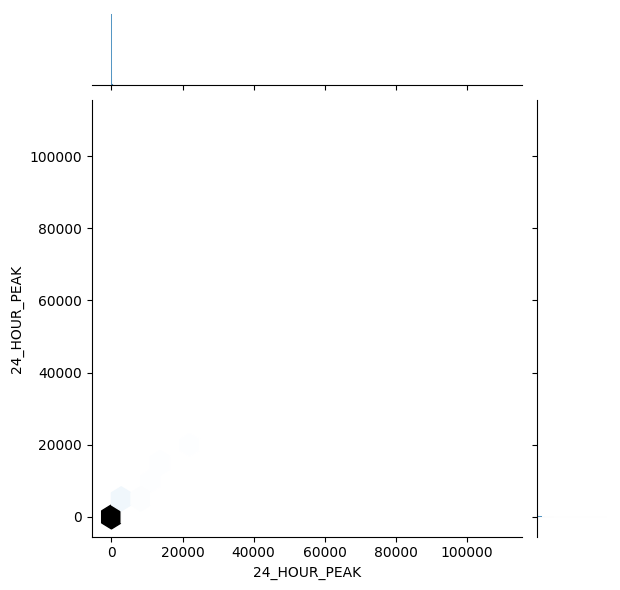

In [566]:
for metric in reviews:
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='hex', gridsize=20)
    plt.xlabel(metric)
    plt.ylabel('24_HOUR_PEAK')
    plt.show()


In [567]:
df.query("RATING_SCORE >= 0.99").sort_values(by="RATING_SCORE", ascending=False)[["NAME", "DEVELOPERS", "RATING_SCORE", "24_HOUR_PEAK"]]

,NAME,DEVELOPERS,RATING_SCORE,24_HOUR_PEAK
26,1792,1080,1.000000,2.0
341,658,1610,1.000000,1.0
1967,505,1121,1.000000,1.0
1929,2009,1387,1.000000,1.0
1092,655,63,1.000000,7.0
...,...,...,...,...
1624,1161,441,0.990215,10.0
1257,793,1527,0.990202,26.0
1022,267,1374,0.990148,7.0
938,377,1429,0.990025,26.0


### Developer Analysis

In [568]:
developer_game_count = df['DEVELOPERS'].value_counts()

developer_24_HOUR_PEAK_summary = df.groupby('DEVELOPERS')['24_HOUR_PEAK'].mean().sort_values(ascending=False)

developer_summary = pd.DataFrame({
    'Game Count': developer_game_count,
    'Average 24_HOUR_PEAK': developer_24_HOUR_PEAK_summary
}).dropna().sort_values(by='Game Count', ascending=False)

developer_summary

,Game Count,Average 24_HOUR_PEAK
DEVELOPERS,,
1420,15,10115.800000
1214,14,422.357143
67,11,2.454545
194,10,1256.800000
1583,7,20.714286
...,...,...
681,1,5.000000
680,1,356.000000
679,1,1898.000000


## Correlation Heatmap

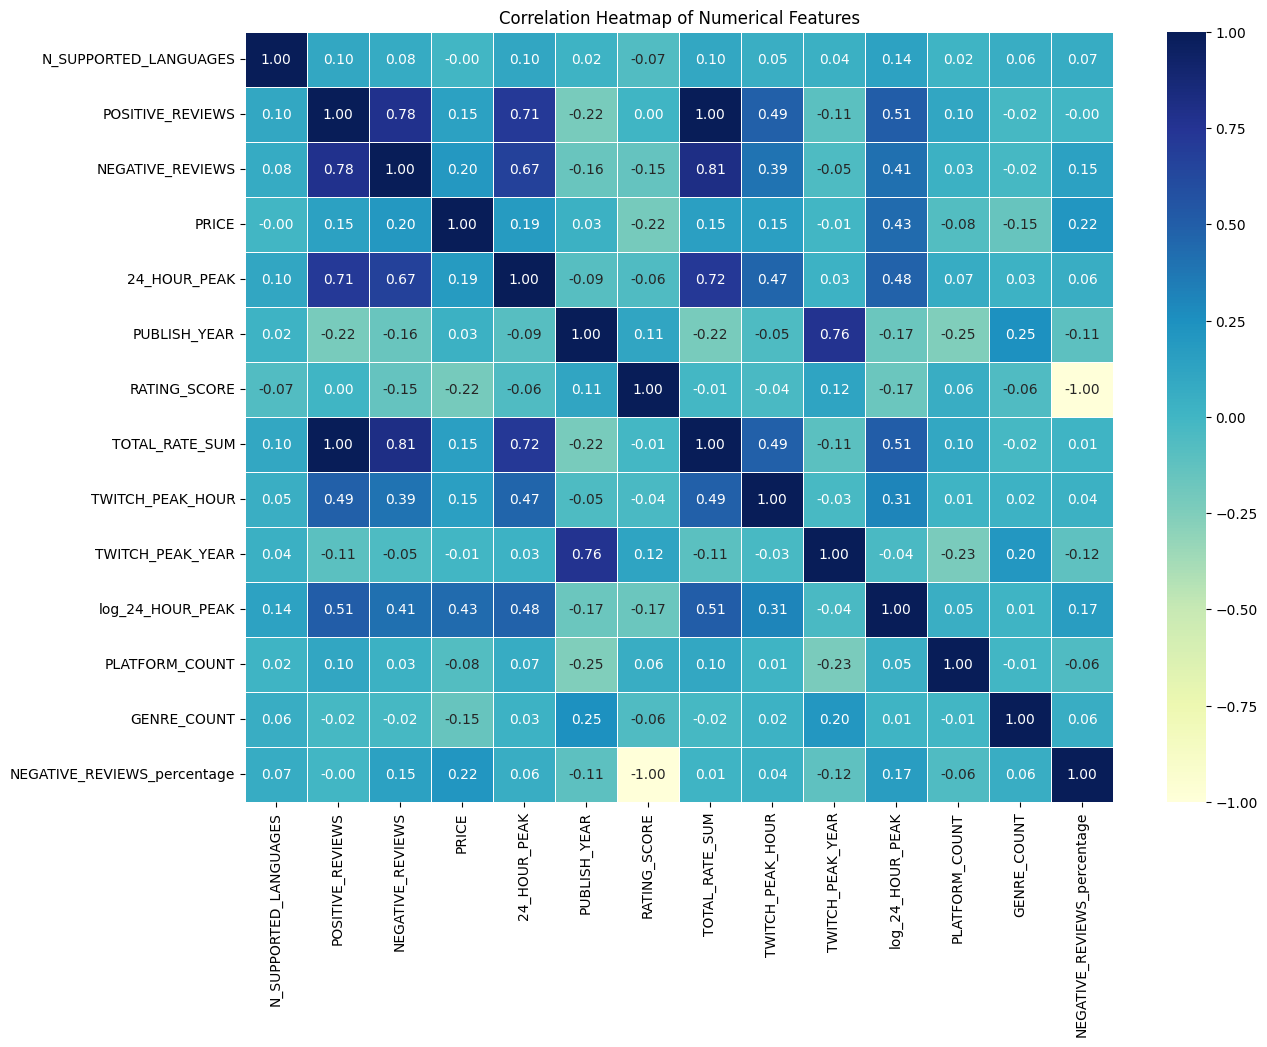

In [569]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

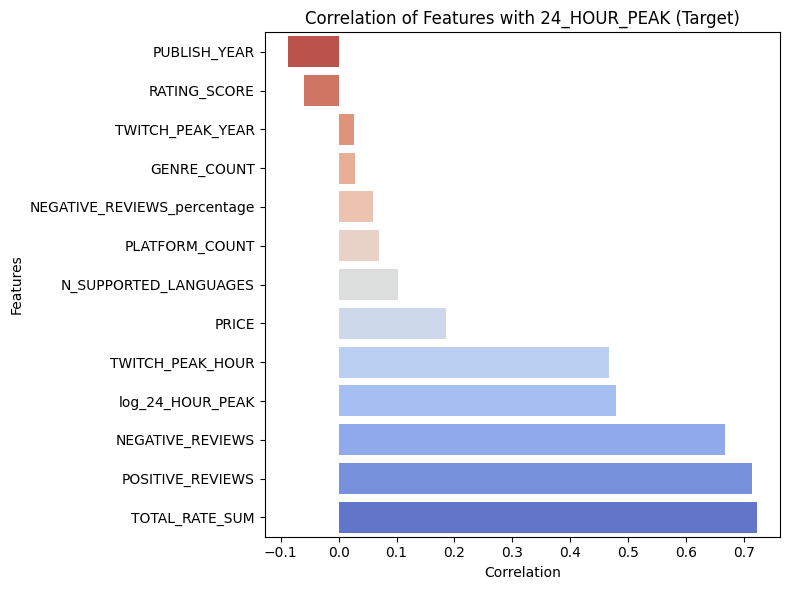

In [570]:
target_correlation = correlation_matrix['24_HOUR_PEAK'].drop('24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


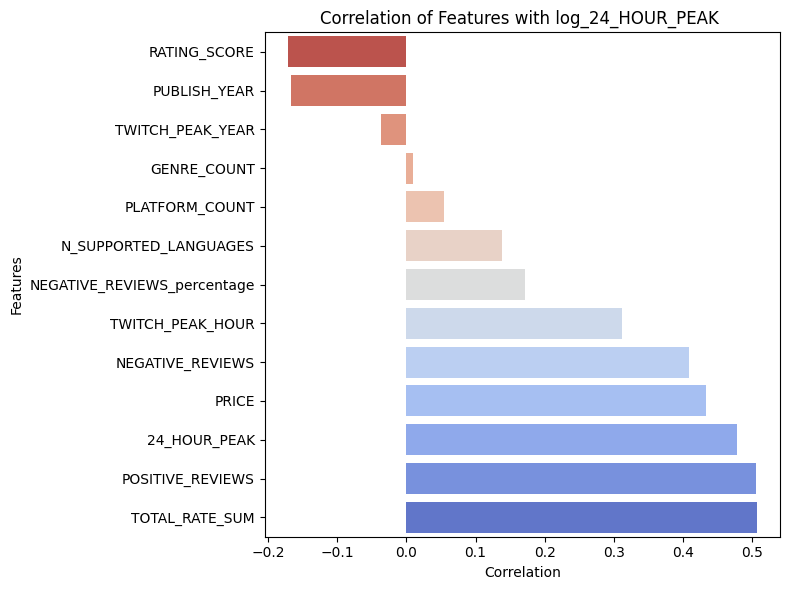

In [571]:
target_correlation = correlation_matrix['log_24_HOUR_PEAK'].drop('log_24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with log_24_HOUR_PEAK ')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


# Evaluation Metric

Choose appropriate evaluation metrics based on the nature of the data and the project goal, and **explain your reasons for choosing them.**

In [572]:
def analysis_model(history, model, X_train, y_train, X_val, y_val, title='Model Performance'):
    if history is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_absolute_error'], label='Train MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
        plt.title('Model Mean Absolute Error')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.show()
    
    # Predictions for train and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics for training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
    
    # Calculate metrics for validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    
    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame({
        'Set': ['Training', 'Validation'],
        'Loss': [train_loss, val_loss],
        'RMSE': [train_rmse, val_rmse],
        'R-squared': [train_r2, val_r2],
        'MAE': [train_mae, val_mae]
    })
    
    print(f'{title} - Evaluation Metrics:')
    return metrics_df

In [610]:
def plot_learning_curve(estimator, X, y, title='Learning Curve', cv=5, scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Score')

    plt.legend(loc='best')
    plt.show()

def print_evaluation_metrics(model, X_test, y_test, title='Model Performance'):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'{title} - Evaluation Metrics:')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-squared: {r2}')

# Feature Selection

In [611]:
target_y = 'log_24_HOUR_PEAK'

In [612]:
if '24_HOUR_PEAK' in df.columns:
    df = df.drop(columns='24_HOUR_PEAK')
    numerical_features.remove('24_HOUR_PEAK')

In [613]:
if technologies[0] in df.columns:
    df = df.drop(columns=technologies)

In [614]:
if 'PRICE' in df.columns:    
    df = df.drop(columns = "PRICE")
    numerical_features.remove('PRICE')

In [578]:
if 'PRICE_CATEGORY' in df.columns:    
    df = df.drop(columns = "PRICE_CATEGORY")

In [579]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NAME                          2032 non-null   int32  
 1   N_SUPPORTED_LANGUAGES         2032 non-null   int64  
 2   DEVELOPERS                    2032 non-null   int32  
 3   POSITIVE_REVIEWS              2032 non-null   int64  
 4   NEGATIVE_REVIEWS              2032 non-null   int64  
 5   PUBLISH_YEAR                  2032 non-null   int64  
 6   RATING_SCORE                  2032 non-null   float64
 7   TOTAL_RATE_SUM                2032 non-null   int64  
 8   TWITCH_PEAK_HOUR              2032 non-null   float64
 9   TWITCH_PEAK_YEAR              2032 non-null   int64  
 10  GENRE: Action                 2032 non-null   int64  
 11  GENRE: Adventure              2032 non-null   int64  
 12  GENRE: Casual                 2032 non-null   int64  
 13  GEN

**Remove highly correlated features (correlation coefficient > 0.9)**

In [580]:
correlation_matrix = df[numerical_features].corr()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(high_correlation)
df_reduced = df.drop(columns=high_correlation)

['TOTAL_RATE_SUM']


**SelectKBest to select top features based on f_regression**

In [581]:
X = df_reduced.drop(target_y, axis=1)
y = df_reduced[target_y]
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")


Selected features: Index(['POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'PUBLISH_YEAR', 'RATING_SCORE',
       'TWITCH_PEAK_HOUR', 'GENRE: Casual', 'GENRE: Indie',
       'GENRE: Simulation', 'GENRE: Strategy', 'NEGATIVE_REVIEWS_percentage'],
      dtype='object')


In [582]:
df_selected = df_reduced[selected_features]
df_selected[target_y] = y

C:\Users\AFRAA\AppData\Local\Temp\ipykernel_15636\3371742647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[target_y] = y


In [583]:
del df_reduced

# Split the dataset into training and testing sets

In [584]:
X_train, X_test, y_train, y_test = train_test_split(df_selected.drop(target_y, axis=1), df_selected[target_y], test_size=0.2, random_state=42)

# Standardization

In [585]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Testing our features

In [586]:
model = Sequential()
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_scaled, y_train, epochs=70, batch_size=16, validation_split=0.2)

Epoch 1/70


C:\Users\AFRAA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.4039 - mean_absolute_error: 3.0865 - val_loss: 8.2360 - val_mean_absolute_error: 1.6481
Epoch 2/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 4.4787 - mean_absolute_error: 1.5766 - val_loss: 9.9409 - val_mean_absolute_error: 1.6177
Epoch 3/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 3.2488 - mean_absolute_error: 1.4575 - val_loss: 10.7561 - val_mean_absolute_error: 1.5790
Epoch 4/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 3.1435 - mean_absolute_error: 1.3863 - val_loss: 9.7570 - val_mean_absolute_error: 1.5546
Epoch 5/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 2.6619 - mean_absolute_error: 1.3198 - val_loss: 10.1989 - val_mean_absolute_error: 1.4957
Epoch 6/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 2.3753 - mean_absolute_error: 1.2225 - val_loss: 9.7394 - val_mean_absolute_error: 1.4186
Epoch 7/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 2.2367 - mean_absolute_error: 1.1619 - val_loss: 8

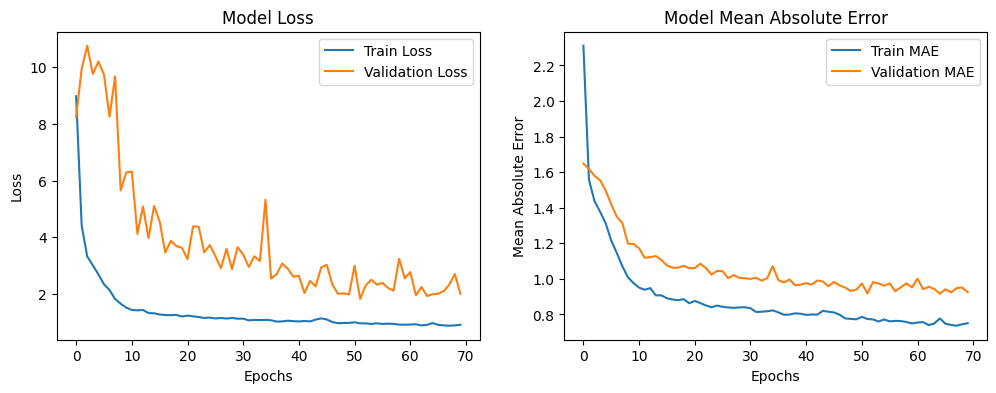

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Model Performance - Evaluation Metrics:


,Set,Loss,RMSE,R-squared,MAE
0,Training,0.814406,0.902445,0.830213,0.703328
1,Validation,2.003121,1.415317,0.596296,0.925493


In [587]:
# Evaluate the model
X_val_scaled = X_train_scaled[int(len(X_train_scaled) * 0.8):]  # Last 20% as validation set
y_val = y_train[int(len(y_train) * 0.8):]  # Last 20% as validation set

analysis_model(history, model, X_train_scaled[:int(len(X_train_scaled) * 0.8)], y_train[:int(len(y_train) * 0.8)], X_val_scaled, y_val)

# Dimensionality Reduction

Using the PCA method, reduce the dimensions of numerical features to two dimensions. 


How much of the initial data variance is transferred to the new space?

If we aim to retain 95% of the original variance, what is the minimum number of dimensio s
required in the new space? Save both the original data and the dimension-reduced one  or
the next parts.

In [ ]:
pca_2D = PCA()
pca_2D_result = pca_2D.fit_transform(X_train_scaled)
explained_variance_2D = pca_2D.explained_variance_ratio_.sum()
print(f"Explained variance: {explained_variance_2D}")


In [ ]:
pca_95 = PCA(0.95)
X_pca_95 = pca_95.fit_transform(X_train_scaled)
print(f"Number of components to retain 95% variance: {pca_95.n_components_}")

In [ ]:
pca_full = PCA().fit(df_selected)
cumulative_variance_explained = pca_full.explained_variance_ratio_.cumsum()
n_components_95 = next(i for i, cumulative_variance in enumerate(cumulative_variance_explained) if cumulative_variance >= 0.95) + 1
pca_95 = PCA(n_components=n_components_95)
pca_95_result = pca_95.fit_transform(df)
print(f"Number of components to retain 95% variance: {n_components_95}")

In [ ]:
# original_data = df_selected
# dimension_reduced_data_2d = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Model Training

In this section, you need to implement three methods to predict your target variable.   
First, split the initial data (including all features) into training and test sets.

## Create the XGBoost regressor object

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Plot the feature importance
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 9]
plt.show()

## Method One:  Neural Network

In [ ]:
# training networks with various parameters
hid_layer_cnts = [16,32,64,128,256]
epochs = [16,32,64,128,200,256,512,1024]
batches = [16,32,64,128]

In [ ]:
# def train_one_layer_models(hid_layer_cnts,epochs,batches):
#     '''
#     Function takes arrays of parameters for a one layer neural network and trains a neural network for every
#     combination of these parameters. Function creates a table (data frame) with RMSE on testing data 
#     for every neural network.
#     '''
#     table_cols = ['# of units per layer', '# of epochs', 'Size of batches', 'RMSE']
#     table = pd.DataFrame(columns = table_cols)
    
#     # model all combinations of parameters
#     for hid in hid_layer_cnts:
#         for e in epochs:
#             for b in batches:
#                 # create model
#                 model = keras.Sequential([
#                     keras.layers.Dense(128, input_dim=46, activation='relu'),
#                     keras.layers.Dropout(0.4),
#                     keras.layers.Dense(hid, activation='relu'),
#                     keras.layers.Dense(1, activation='relu')
#                 ])

#                 # Compile model
#                 model.compile(loss='mean_squared_error', optimizer='adam')

#                 # Fit the model
#                 model.fit(X_train, y_train, epochs=e, batch_size=b, verbose=0, validation_split=0.1)

#                 # predict targets for testing data
#                 y_pred = model.predict(X_test)

#                 # compute RMSE
#                 rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

#                 run = pd.Series( \
#                         {'# of units per layer':hid,'# of epochs':e,'Size of batches':b,'RMSE':rmse} \
#                       )
#                 table = table.append(run, ignore_index=True)
#     return table

In [590]:
model = Sequential()
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_scaled, y_train, epochs=70, batch_size=16, validation_split=0.2)

Epoch 1/70


C:\Users\AFRAA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.1228 - mean_absolute_error: 2.9344 - val_loss: 9.5839 - val_mean_absolute_error: 1.6673
Epoch 2/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 3.6262 - mean_absolute_error: 1.5127 - val_loss: 8.5576 - val_mean_absolute_error: 1.5969
Epoch 3/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 4.1253 - mean_absolute_error: 1.5585 - val_loss: 10.1399 - val_mean_absolute_error: 1.5950
Epoch 4/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 3.1265 - mean_absolute_error: 1.4243 - val_loss: 8.1853 - val_mean_absolute_error: 1.5682
Epoch 5/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 3.0969 - mean_absolute_error: 1.4078 - val_loss: 10.1580 - val_mean_absolute_error: 1.5560
Epoch 6/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 2.8938 - mean_absolute_error: 1.3499 - val_loss: 8.7456 - val_mean_absolute_error: 1.5158
Epoch 7/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 2.4842 - mean_absolute_error: 1.2354 - val_loss: 8

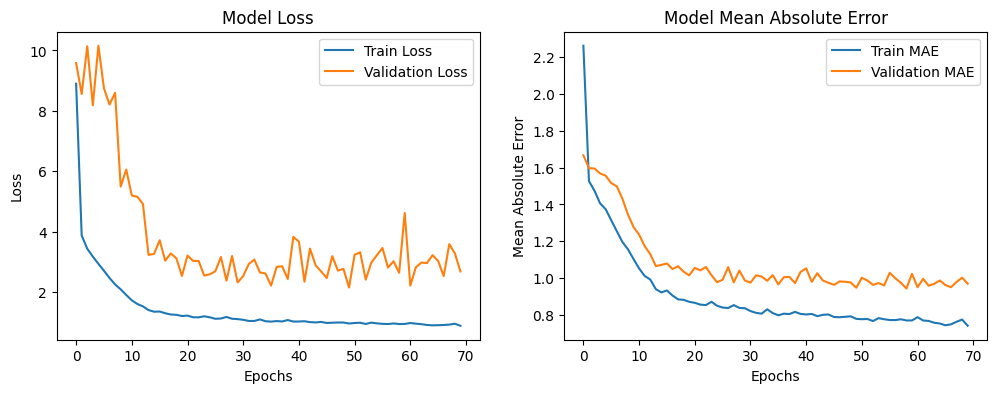

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
Model Performance - Evaluation Metrics:


,Set,Loss,RMSE,R-squared,MAE
0,Training,0.863944,0.929486,0.819885,0.735135
1,Validation,2.688028,1.639521,0.458262,0.968869


In [591]:
# Evaluate the model
X_val_scaled = X_train_scaled[int(len(X_train_scaled) * 0.8):]  # Last 20% as validation set
y_val = y_train[int(len(y_train) * 0.8):]  # Last 20% as validation set

analysis_model(history, model, X_train_scaled[:int(len(X_train_scaled) * 0.8)], y_train[:int(len(y_train) * 0.8)], X_val_scaled, y_val)

In [592]:
table_cols = ['# of units per layer', '# of epochs', 'Size of batches', 'Training time', 'RMSE']
table2 = pd.DataFrame(columns = table_cols)

param_sets = [[16,32,64],[256,200,16],[16,200,16],[16,128,16]]
# create and train a model for each parameter set
for ps in param_sets:
    # create model
    model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.4),
        Dense(ps[0], activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')


   
    # Fit the model
    train_start = dt.datetime.now()
    history = model.fit(X_train_scaled, y_train, epochs=ps[1], batch_size=ps[2], verbose=0, validation_split=0.1)

    train_end = dt.datetime.now()
    train_duration = train_end - train_start
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Compute RMSE for train and test data
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Compute R2 for train and test data
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    run = pd.DataFrame({
        '# of units per layer': [ps[0]],
        '# of epochs': [ps[1]],
        'Size of batches': [ps[2]],
        'Training time': [train_duration],
        'RMSE (Train)': [rmse_train],
        'R2 (Train)': [r2_train],
        'RMSE (Test)': [rmse_test],
        'R2 (Test)': [r2_test]
    })

    # Append the new row to the table
    table2 = pd.concat([table2, run], ignore_index=True)

C:\Users\AFRAA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


C:\Users\AFRAA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


C:\Users\AFRAA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


C:\Users\AFRAA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


In [593]:
# results:
table2

,# of units per layer,# of epochs,Size of batches,Training time,RMSE,RMSE (Train),R2 (Train),RMSE (Test),R2 (Test)
0,16,32,64,0 days 00:00:02.059574,NaN,1.605049,0.466601,1.553800,0.485222
1,256,200,16,0 days 00:00:17.336355,NaN,0.994347,0.795284,1.172325,0.706961
2,16,200,16,0 days 00:00:17.283955,NaN,1.078709,0.759074,1.162157,0.712022
3,16,128,16,0 days 00:00:10.510885,NaN,1.056409,0.768932,1.207777,0.688969


## Methods Two

Fitting 5 folds for each of 96 candidates, totalling 480 fits


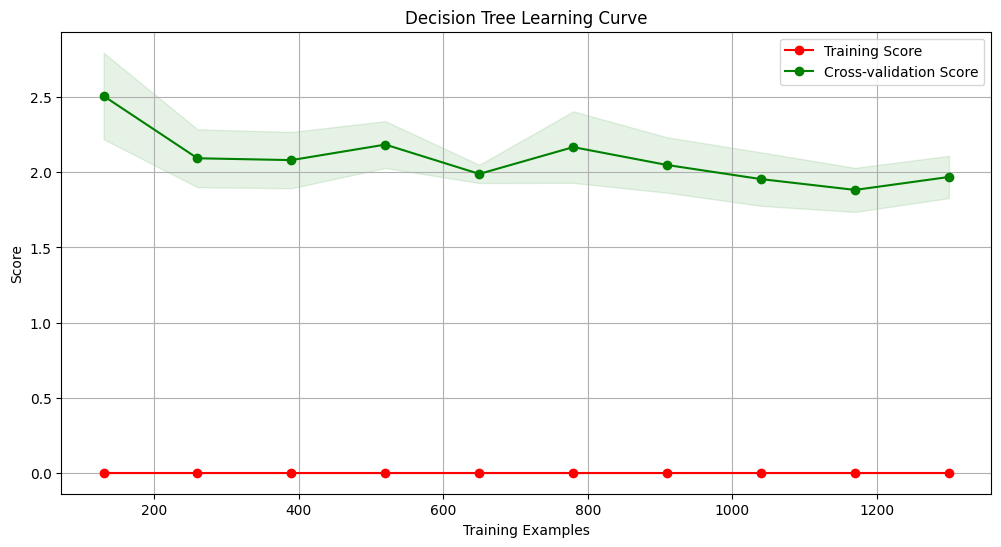

Decision Tree - Evaluation Metrics:
Mean Absolute Error (MAE): 0.9059665894044651
Root Mean Squared Error (RMSE): 1.1789404747779513
R-squared: 0.7036442185433404


In [615]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10]
}

# Initialize and fit GridSearchCV with verbose=3 for detailed output
dt_model = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

# Best estimator
best_dt_model = grid_search.best_estimator_

# Plot learning curve
plot_learning_curve(dt_model, X_train, y_train, title='Decision Tree Learning Curve')

# Print evaluation metrics
print_evaluation_metrics(best_dt_model, X_test, y_test, title='Decision Tree')


## Methods Three

In [617]:
param_grid = {
    'kernel': ['linear'],
    'C': [0.1],
    'epsilon': [0.015]
}

# Initialize and fit GridSearchCV
svm_model = SVR()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error',  verbose=3)
grid_search.fit(X_train, y_train)

# Best estimator
best_svm_model = grid_search.best_estimator_

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
# Plot learning curve
plot_learning_curve(svm_model, X_train, y_train, title='Support Vector Machine Learning Curve')

# Print evaluation metrics
print_evaluation_metrics(svm_model, X_test, y_test, title='Support Vector Machine')

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

# Feature Analysis

Train the best-performing method from the previous section using the dimension-reduced data. 
**How did the model performance change? Provide your analysis.**